# Research Problem

Educational researchers and data scientists face significant challenges in identifying struggling students early enough to provide timely interventions in online learning environments. While there are extensive data available, extracting meaningful predictive signals from student interactions remains difficult, particularly within the first portion of assignments when intervention would be most valuable. [The ASSISTments dataset](https://osf.io/59shv/files/osfstorage) provides a unique opportunity to address this challenge through its comprehensive data from 88 distinct assignment-level randomized controlled experiments conducted within [the ASSISTments platform](https://www.assistments.org/). This collection, analyzed initially in [Prihar et al.'s 2022 paper *Exploring Common Trends in Online Educational Experiments*](https://osf.io/f58dz), includes detailed clickstream data that captures temporal aspects of student engagement across diverse educational interventions. The rich multi-level student interaction data enables the development and evaluation of early warning systems that could identify struggling students before they fall significantly behind.

# Research Question

How can temporal engagement features derived from clickstream data in the ASSISTments experimental dataset predict student performance drops across different intervention types, and which feature selection methods most effectively identify at-risk students within the first 25% of an assignment? This research will leverage the dataset's granular student interaction logs to extract time-based engagement patterns, analyze how these patterns correlate with performance outcomes, and determine which combinations of features provide the earliest reliable signals of academic struggle across different intervention conditions.

# Load, Merge, and Clean Data

In [1]:
# Setup and Configuration
import polars as pl
from pathlib import Path
import gc

# --- Enable Global String Cache for Categoricals ---
pl.enable_string_cache()

# --- Configuration ---
BASE_DATA_PATH = Path('/Users/john/Downloads/osfstorage-archive')
EXPERIMENT_IDS_PATH = BASE_DATA_PATH / 'experiment_dataset_2021-09-23'

# Output path for the cleaned data
SAVE_CLEANED_PATH_POLARS_PARQUET = BASE_DATA_PATH / 'merged_experiment_data_cleaned_polars.parquet'
SAVE_CLEANED_PATH_POLARS_CSV = BASE_DATA_PATH / 'merged_experiment_data_cleaned_polars.csv'

print(f"Polars version: {pl.__version__}")
print(f"Base data path: {BASE_DATA_PATH}")
print(f"Experiment IDs path: {EXPERIMENT_IDS_PATH}")
print(f"Global String Cache enabled: {pl.using_string_cache()}")

Polars version: 1.29.0
Base data path: /Users/john/Downloads/osfstorage-archive
Experiment IDs path: /Users/john/Downloads/osfstorage-archive/experiment_dataset_2021-09-23
Global String Cache enabled: True


In [2]:
# Generate File Paths
try:
    if not EXPERIMENT_IDS_PATH.is_dir():
        raise FileNotFoundError(f"Error: Directory not found at {EXPERIMENT_IDS_PATH}")
    experiment_ids = [d.name for d in EXPERIMENT_IDS_PATH.iterdir() if d.is_dir()]
    print(f"Found {len(experiment_ids)} experiment ID directories.")
except FileNotFoundError as e:
    print(e)
    experiment_ids = []

performance_file_paths = [str(EXPERIMENT_IDS_PATH / exp_id / 'exp_alogs.csv') for exp_id in experiment_ids]
problems_file_paths = [str(EXPERIMENT_IDS_PATH / exp_id / 'exp_plogs.csv') for exp_id in experiment_ids]
actions_file_paths = [str(EXPERIMENT_IDS_PATH / exp_id / 'exp_slogs.csv') for exp_id in experiment_ids]
metrics_file_paths = [str(EXPERIMENT_IDS_PATH / exp_id / 'priors.csv') for exp_id in experiment_ids]

print("Sample performance file paths:", performance_file_paths[:2])
print("Sample problems file paths:", problems_file_paths[:2])
print("Sample actions file paths:", actions_file_paths[:2])
print("Sample metrics file paths:", metrics_file_paths[:2])

Found 88 experiment ID directories.
Sample performance file paths: ['/Users/john/Downloads/osfstorage-archive/experiment_dataset_2021-09-23/PSAU85Y/exp_alogs.csv', '/Users/john/Downloads/osfstorage-archive/experiment_dataset_2021-09-23/PSAXD6K/exp_alogs.csv']
Sample problems file paths: ['/Users/john/Downloads/osfstorage-archive/experiment_dataset_2021-09-23/PSAU85Y/exp_plogs.csv', '/Users/john/Downloads/osfstorage-archive/experiment_dataset_2021-09-23/PSAXD6K/exp_plogs.csv']
Sample actions file paths: ['/Users/john/Downloads/osfstorage-archive/experiment_dataset_2021-09-23/PSAU85Y/exp_slogs.csv', '/Users/john/Downloads/osfstorage-archive/experiment_dataset_2021-09-23/PSAXD6K/exp_slogs.csv']
Sample metrics file paths: ['/Users/john/Downloads/osfstorage-archive/experiment_dataset_2021-09-23/PSAU85Y/priors.csv', '/Users/john/Downloads/osfstorage-archive/experiment_dataset_2021-09-23/PSAXD6K/priors.csv']


In [3]:
# Define Schemas and Date Parsing Information

actions_schema = {
    'experiment_id': pl.Categorical,
    'student_id': pl.Categorical,
    'problem_id': pl.Categorical,
    'problem_part': pl.Categorical, 
    'scaffold_id': pl.Categorical,  
    'experiment_tag_path': pl.Utf8,
    'action': pl.Categorical,
    'timestamp': pl.Utf8,
    'assistments_reference_action_log_id': pl.UInt64
}
actions_parse_dates = ['timestamp']

problems_schema = {
    'experiment_id': pl.Categorical,
    'student_id': pl.Categorical,
    'problem_id': pl.Categorical,
    'problem_part': pl.Categorical, 
    'scaffold_id': pl.Categorical,  
    'problem_condition': pl.Categorical,
    'start_time': pl.Utf8,
    'end_time': pl.Utf8,
    'session_count': pl.UInt16,
    'time_on_task': pl.Float32,
    'first_response_or_request_time': pl.Float32,
    'first_answer': pl.Utf8,
    'correct': pl.Boolean,
    'reported_score': pl.Float32,
    'answer_before_tutoring': pl.Boolean,
    'attempt_count': pl.UInt16,
    'hints_available': pl.UInt16,
    'hints_given': pl.UInt16,
    'scaffold_problems_available': pl.UInt16,
    'scaffold_problems_given': pl.UInt16,
    'explanation_available': pl.Boolean,
    'explanation_given': pl.Boolean,
    'answer_given': pl.Boolean,
    'assistments_reference_problem_log_id': pl.UInt64
}
problems_parse_dates = ['start_time', 'end_time']

performance_schema = {
    'experiment_id': pl.Categorical,
    'student_id': pl.Categorical,
    'release_date': pl.Utf8,
    'due_date': pl.Utf8,
    'start_time': pl.Utf8,
    'end_time': pl.Utf8,
    'assignment_session_count': pl.Float32,
    'pretest_problem_count': pl.Float32,
    'pretest_correct': pl.Float32,
    'pretest_time_on_task': pl.Float32,
    'pretest_average_first_response_time': pl.Float32,
    'pretest_session_count': pl.Float32,
    'assigned_condition': pl.Categorical,
    'condition_time_on_task': pl.Float32,
    'condition_average_first_response_or_request_time': pl.Float32,
    'condition_problem_count': pl.Float32,
    'condition_total_correct': pl.Float32,
    'condition_total_correct_after_wrong_response': pl.Float32,
    'condition_total_correct_after_tutoring': pl.Float32,
    'condition_total_answers_before_tutoring': pl.Float32,
    'condition_total_attempt_count': pl.Float32,
    'condition_total_hints_available': pl.Float32,
    'condition_total_hints_given': pl.Float32,
    'condition_total_scaffold_problems_available': pl.Float32,
    'condition_total_scaffold_problems_given': pl.Float32,
    'condition_total_explanations_available': pl.Float32,
    'condition_total_explanations_given': pl.Float32,
    'condition_total_answers_given': pl.Float32,
    'condition_session_count': pl.Float32,
    'posttest_problem_count': pl.Float32,
    'posttest_correct': pl.Float32,
    'posttest_time_on_task': pl.Float32,
    'posttest_average_first_response_time': pl.Float32,
    'posttest_session_count': pl.Float32,
    'assistments_reference_assignment_log_id': pl.UInt64
}
performance_parse_dates = ['release_date', 'due_date', 'start_time', 'end_time']

metrics_schema = {
    'experiment_id': pl.Categorical,
    'student_id': pl.Categorical,
    'student_prior_started_skill_builder_count': pl.UInt32,
    'student_prior_completed_skill_builder_count': pl.UInt32,
    'student_prior_started_problem_set_count': pl.UInt32,
    'student_prior_completed_problem_set_count': pl.UInt32,
    'student_prior_completed_problem_count': pl.UInt32,
    'student_prior_median_first_response_time': pl.Float32,
    'student_prior_median_time_on_task': pl.Float32,
    'student_prior_average_correctness': pl.Float32,
    'student_prior_average_attempt_count': pl.Float32,
    'class_id': pl.Categorical,
    'class_creation_date': pl.Utf8,
    'class_student_count': pl.UInt16,
    'class_prior_skill_builder_count': pl.UInt32,
    'class_prior_problem_set_count': pl.UInt32,
    'class_prior_skill_builder_percent_started': pl.Float32,
    'class_prior_skill_builder_percent_completed': pl.Float32,
    'class_prior_problem_set_percent_started': pl.Float32,
    'class_prior_problem_set_percent_completed': pl.Float32,
    'class_prior_completed_problem_count': pl.UInt32,
    'class_prior_median_time_on_task': pl.Float32,
    'class_prior_median_first_response_time': pl.Float32,
    'class_prior_average_correctness': pl.Float32,
    'class_prior_average_attempt_count': pl.Float32,
    'teacher id': pl.Categorical, 
    'teacher_account_creation_date': pl.Utf8,
    'district_id': pl.Categorical,
    'location': pl.Categorical,
    'opportunity_zone': pl.Categorical,
    'locale_description': pl.Categorical
}
metrics_parse_dates = ['class_creation_date', 'teacher_account_creation_date']

In [4]:
# Helper Function for Memory-Efficient CSV Concatenation

def combine_polars_csvs(file_paths, schema=None, parse_dates_list=None,
                        known_date_format_str: str = None,
                        date_time_unit='us'):
    lazy_frames = []
    print(f"\nScanning {len(file_paths)} files...")

    common_columns_from_first_file = None
    if file_paths and schema:
        try:
            common_columns_from_first_file = pl.scan_csv(
                file_paths[0], infer_schema_length=100, n_rows=10
            ).collect_schema().names()
        except Exception as e:
            print(f"  Warning: Could not determine common columns from first file {file_paths[0]}: {e}")
            common_columns_from_first_file = list(schema.keys())

    problematic_file_for_date_parse = None
    current_col_for_date_parse = "unknown"

    for i, file_path_str in enumerate(file_paths):
        file_path = Path(file_path_str)
        if i % 10 == 0:
            print(f"  Scanning file {i+1}/{len(file_paths)}: {file_path.parent.name}/{file_path.name}")

        try:
            lf = pl.scan_csv(file_path,
                             schema=schema,
                             infer_schema_length=100,
                             null_values=["", "NA", "NaN", "null"])

            if parse_dates_list:
                date_parsing_expressions = []
                columns_to_check_for_dates = common_columns_from_first_file if common_columns_from_first_file else lf.collect_schema().names()

                for col_name in parse_dates_list:
                    current_col_for_date_parse = col_name
                    if col_name in columns_to_check_for_dates:
                        if col_name not in lf.collect_schema().names():
                            continue

                        date_expr = pl.col(col_name).cast(pl.Utf8, strict=False)

                        if known_date_format_str:
                            date_expr = date_expr.str.to_datetime(
                                format=known_date_format_str,
                                strict=False,
                                time_unit=date_time_unit
                            )
                        else:
                            date_expr = date_expr.str.to_datetime(
                                strict=False,
                                time_unit=date_time_unit
                            )
                        date_parsing_expressions.append(
                            date_expr.dt.convert_time_zone("UTC").alias(col_name)
                        )
                if date_parsing_expressions:
                    lf = lf.with_columns(date_parsing_expressions)

            lazy_frames.append(lf)
            problematic_file_for_date_parse = None

        except FileNotFoundError:
            print(f"  Warning: File not found, skipping: {file_path}")
        except pl.exceptions.NoDataError:
             print(f"  Warning: File is empty, skipping: {file_path}")
        except Exception as e:
            problematic_file_for_date_parse = file_path
            if "strptime" in str(e).lower() or "conversion" in str(e).lower() or "datetime" in str(e).lower():
                 print(f"  Potential date parsing error for {problematic_file_for_date_parse} (column likely '{current_col_for_date_parse}'): {e}")
            else:
                print(f"  Error scanning {file_path} or applying initial transforms: {e}")


    if not lazy_frames:
        print("  No lazy frames were created from scanning files.")
        return None

    print(f"Concatenating {len(lazy_frames)} lazy frames...")
    try:
        combined_lf = pl.concat(lazy_frames, how="vertical_relaxed")
        print("Collecting data into DataFrame (streaming enabled)...")
        # Reverted to engine="streaming" as per deprecation warning for Polars 1.29.0
        collected_df = combined_lf.collect(engine="streaming")
        print("Concatenation and collection complete.")
        return collected_df
    except Exception as e:
        print(f"Error during lazy concatenation or collection: {e}")
        if problematic_file_for_date_parse:
            print(f"  This might be related to an earlier issue in file: {problematic_file_for_date_parse}")
        return None

In [5]:
# Load DataFrames

COMMON_DATETIME_FORMAT = "%Y-%m-%d %H:%M:%S%.f%z" 

print("Combining Actions Data (exp_slogs)...")
actions_df = combine_polars_csvs(
    actions_file_paths, 
    schema=actions_schema, 
    parse_dates_list=actions_parse_dates,
    known_date_format_str=COMMON_DATETIME_FORMAT 
)
if actions_df is not None:
    print(f"Actions DataFrame shape: {actions_df.shape}")

print("\nCombining Problems Data (exp_plogs)...")
problems_df = combine_polars_csvs(
    problems_file_paths, 
    schema=problems_schema, 
    parse_dates_list=problems_parse_dates,
    known_date_format_str=COMMON_DATETIME_FORMAT 
)
if problems_df is not None:
    print(f"Problems DataFrame shape: {problems_df.shape}")

print("\nCombining Performance Data (exp_alogs)...")
performance_df = combine_polars_csvs(
    performance_file_paths, 
    schema=performance_schema, 
    parse_dates_list=performance_parse_dates,
    known_date_format_str=COMMON_DATETIME_FORMAT
)
if performance_df is not None:
    print(f"Performance DataFrame shape: {performance_df.shape}")

print("\nCombining Metrics Data (priors)...")
if 'teacher id' in metrics_schema: 
    metrics_schema_corrected = metrics_schema.copy()
    metrics_schema_corrected['teacher_id'] = metrics_schema_corrected.pop('teacher id')
else:
    metrics_schema_corrected = metrics_schema

metrics_df = combine_polars_csvs(
    metrics_file_paths, 
    schema=metrics_schema_corrected, 
    parse_dates_list=metrics_parse_dates,
    known_date_format_str=COMMON_DATETIME_FORMAT
)
if metrics_df is not None:
    if 'teacher id' in metrics_df.columns: 
        metrics_df = metrics_df.rename({'teacher id': 'teacher_id'})
    print(f"Metrics DataFrame shape: {metrics_df.shape}")

gc.collect()

Combining Actions Data (exp_slogs)...

Scanning 88 files...
  Scanning file 1/88: PSAU85Y/exp_slogs.csv
  Scanning file 11/88: PSAYCFH/exp_slogs.csv
  Scanning file 21/88: PSAZ2G4/exp_slogs.csv
  Scanning file 31/88: PSAQJFP/exp_slogs.csv
  Scanning file 41/88: PSAJVP8/exp_slogs.csv
  Scanning file 51/88: PSA9XWV/exp_slogs.csv
  Scanning file 61/88: PSAM4NK/exp_slogs.csv
  Scanning file 71/88: PSATP2Z/exp_slogs.csv
  Scanning file 81/88: PSASDZY/exp_slogs.csv
Concatenating 88 lazy frames...
Concatenation and collection complete.
Actions DataFrame shape: (3708299, 9)

Combining Problems Data (exp_plogs)...

Scanning 88 files...
  Scanning file 1/88: PSAU85Y/exp_plogs.csv
  Scanning file 11/88: PSAYCFH/exp_plogs.csv
  Scanning file 21/88: PSAZ2G4/exp_plogs.csv
  Scanning file 31/88: PSAQJFP/exp_plogs.csv
  Scanning file 41/88: PSAJVP8/exp_plogs.csv
  Scanning file 51/88: PSA9XWV/exp_plogs.csv
  Scanning file 61/88: PSAM4NK/exp_plogs.csv
  Scanning file 71/88: PSATP2Z/exp_plogs.csv
  Scan

1028

In [6]:
# Merge DataFrames into One

merged_df = None
merge_successful = True

print("\n--- Starting Merge Operations ---")

if actions_df is None or actions_df.is_empty():
    print("Actions DataFrame is empty or None. Cannot proceed with merge.")
    merge_successful = False
else:
    merged_df = actions_df.clone()
    print(f"Starting with actions_df: {merged_df.shape}")

    # Merge Problems Data
    if problems_df is not None and not problems_df.is_empty() and merge_successful:
        try:
            print("Merging problems_df...")
            problem_keys = ['experiment_id', 'student_id', 'problem_id', 'problem_part', 'scaffold_id']
            merged_df = merged_df.join(problems_df, on=problem_keys, how="left", suffix="_problem")
            print(f"After merging problems_df: {merged_df.shape}")
            del problems_df 
            gc.collect()
        except Exception as e:
            print(f"Error merging problems_df: {e}")
            merge_successful = False
    elif merge_successful: 
        print("Skipping problems_df merge (not loaded or empty).")

    # Merge Performance Data
    if performance_df is not None and not performance_df.is_empty() and merge_successful:
        try:
            print("Merging performance_df...")
            perf_keys = ['experiment_id', 'student_id']
            merged_df = merged_df.join(performance_df, on=perf_keys, how="left", suffix="_perf")
            print(f"After merging performance_df: {merged_df.shape}")
            del performance_df
            gc.collect()
        except Exception as e:
            print(f"Error merging performance_df: {e}")
            merge_successful = False
    elif merge_successful:
        print("Skipping performance_df merge (not loaded or empty).")

    # Merge Metrics Data
    if metrics_df is not None and not metrics_df.is_empty() and merge_successful:
        try:
            print("Merging metrics_df...")
            metrics_keys = ['experiment_id', 'student_id']
            merged_df = merged_df.join(metrics_df, on=metrics_keys, how="left", suffix="_metrics")
            print(f"After merging metrics_df: {merged_df.shape}")
            del metrics_df
            gc.collect()
        except Exception as e:
            print(f"Error merging metrics_df: {e}")
            merge_successful = False
    elif merge_successful:
        print("Skipping metrics_df merge (not loaded or empty).")

    if merged_df is not None and merge_successful:
        print("\n--- Merge Complete ---")
        print("Final Merged DataFrame Info:")
        print(f"Shape: {merged_df.shape}")
        print("Columns in merged_df:", merged_df.columns)
        print(merged_df.head)
        print(merged_df.schema)
        
        if 'actions_df' in locals() and actions_df is not merged_df: 
            del actions_df
            gc.collect()
            
    elif merged_df is not None: 
        print("\n--- Merge Partially Complete or Some DataFrames Skipped ---")
        print("Columns in partially merged_df:", merged_df.columns)
    else: 
        print("\n--- Merge Failed or Base DataFrame (actions_df) was not suitable ---")


--- Starting Merge Operations ---
Starting with actions_df: (3708299, 9)
Merging problems_df...
After merging problems_df: (3708299, 28)
Merging performance_df...
After merging performance_df: (3711215, 61)
Merging metrics_df...
After merging metrics_df: (3711215, 90)

--- Merge Complete ---
Final Merged DataFrame Info:
Shape: (3711215, 90)
Columns in merged_df: ['experiment_id', 'student_id', 'problem_id', 'problem_part', 'scaffold_id', 'experiment_tag_path', 'action', 'timestamp', 'assistments_reference_action_log_id', 'problem_condition', 'start_time', 'end_time', 'session_count', 'time_on_task', 'first_response_or_request_time', 'first_answer', 'correct', 'reported_score', 'answer_before_tutoring', 'attempt_count', 'hints_available', 'hints_given', 'scaffold_problems_available', 'scaffold_problems_given', 'explanation_available', 'explanation_given', 'answer_given', 'assistments_reference_problem_log_id', 'release_date', 'due_date', 'start_time_perf', 'end_time_perf', 'assignment_

# Data Cleaning

In [7]:
# Data Cleaning

if 'merged_df' in locals() and merged_df is not None and merge_successful: 
    print("\n--- Starting Data Cleaning ---")
    print(f"Initial merged_df shape for cleaning: {merged_df.shape}")

    print("\n--- Renaming Columns ---")
    rename_map = {
        'assistments_reference_action_log_id': 'action_log_id',
        'start_time_perf': 'assignment_start_time',
        'end_time_perf': 'assignment_end_time',
        'assistments_reference_assignment_log_id': 'assignment_log_id'
    }
    actual_renames = {k: v for k, v in rename_map.items() if k in merged_df.columns}
    if actual_renames:
        print(f"Applying renames: {actual_renames}")
        merged_df = merged_df.rename(actual_renames)
    else:
        print("No columns matched for renaming based on the current rename_map.")

    column_transformations = []

    datetime_cols_final_check = [
        'timestamp', 'start_time', 'end_time', 'release_date', 'due_date',
        'assignment_start_time', 'assignment_end_time',
        'class_creation_date', 'teacher_account_creation_date'
    ]
    for col_name in datetime_cols_final_check:
        if col_name in merged_df.columns:
            current_dtype = merged_df[col_name].dtype
            if current_dtype == pl.Utf8:
                print(f"Scheduled for datetime re-parsing (UTF8 found): {col_name}")
                column_transformations.append(
                    pl.col(col_name).str.to_datetime(format=COMMON_DATETIME_FORMAT, strict=False, time_unit='us')
                    .dt.convert_time_zone("UTC")
                    .alias(col_name)
                )
            elif isinstance(current_dtype, pl.Datetime):
                current_tz = current_dtype.time_zone
                if current_tz is None:
                    print(f"Info: Datetime column '{col_name}' is naive. Localizing to UTC.")
                    column_transformations.append(
                        pl.col(col_name).dt.replace_time_zone("UTC", ambiguous='earliest').alias(col_name)
                    )
                elif current_tz != "UTC":
                    print(f"Scheduled for UTC conversion (already datetime, was '{current_tz}'): {col_name}")
                    column_transformations.append(
                        pl.col(col_name).dt.convert_time_zone("UTC").alias(col_name)
                    )

    cols_to_category_polars = [
        'experiment_id', 'student_id', 'problem_id', 'problem_part', 'scaffold_id',
        'experiment_tag_path', 'action', 'problem_condition', 'assigned_condition',
        'class_id', 'district_id', 'location', 'opportunity_zone',
        'locale_description', 'teacher_id'
    ]
    for col_name in cols_to_category_polars:
        if col_name in merged_df.columns and merged_df[col_name].dtype != pl.Categorical:
             column_transformations.append(pl.col(col_name).cast(pl.Categorical).alias(col_name))
             print(f"Scheduled for categorical conversion: {col_name}")

    float_to_int_casts = {
        'assignment_session_count': pl.UInt16, 'pretest_problem_count': pl.UInt16,
        'pretest_correct': pl.UInt16, 'pretest_session_count': pl.UInt16,
        'condition_problem_count': pl.UInt16, 'condition_total_correct': pl.UInt16,
        'condition_total_correct_after_wrong_response': pl.UInt16,
        'condition_total_correct_after_tutoring': pl.UInt16,
        'condition_total_answers_before_tutoring': pl.UInt16,
        'condition_total_attempt_count': pl.UInt32,
        'condition_total_hints_available': pl.UInt32, 'condition_total_hints_given': pl.UInt32,
        'condition_total_scaffold_problems_available': pl.UInt32,
        'condition_total_scaffold_problems_given': pl.UInt32,
        'condition_total_explanations_available': pl.UInt32,
        'condition_total_explanations_given': pl.UInt32,
        'condition_total_answers_given': pl.UInt32,
        'condition_session_count': pl.UInt16, 'posttest_problem_count': pl.UInt16,
        'posttest_correct': pl.UInt16, 'posttest_session_count': pl.UInt16,
    }
    for col_name, target_int_type in float_to_int_casts.items():
        if col_name in merged_df.columns:
            if merged_df[col_name].dtype == pl.Float32:
                column_transformations.append(
                    pl.col(col_name)
                      .fill_null(0)
                      .cast(target_int_type, strict=False)
                      .alias(col_name)
                )
                print(f"Scheduled '{col_name}' for Float32 to {target_int_type} conversion.")
            elif merged_df[col_name].dtype != target_int_type:
                print(f"Warning: Column '{col_name}' was expected to be Float32 for int conversion, but found {merged_df[col_name].dtype}. Skipping specific int cast.")

    # General Float64 to Float32 pass
    float64_cols = [col_name for col_name, dtype in merged_df.schema.items() if dtype == pl.Float64]
    for col_name in float64_cols:
        if col_name in merged_df.columns:
            column_transformations.append(pl.col(col_name).cast(pl.Float32).alias(col_name))
            print(f"Scheduled for Float64 to Float32 conversion: {col_name}")

    if column_transformations:
        print("\nApplying column type transformations...")
        merged_df = merged_df.with_columns(column_transformations)
        print("Type transformations applied.")

    print("\n--- Specific Value Cleaning ---")
    specific_value_cleaning_expressions = []

    if 'opportunity_zone' in merged_df.columns:
        if merged_df['opportunity_zone'].dtype != pl.Categorical:
             merged_df = merged_df.with_columns(pl.col('opportunity_zone').cast(pl.Categorical))
        specific_value_cleaning_expressions.append(
            pl.when(pl.col('opportunity_zone').cast(pl.Utf8) == "Yes").then(True)
              .when(pl.col('opportunity_zone').cast(pl.Utf8) == "No").then(False)
              .otherwise(None)
              .cast(pl.Boolean)
              .alias('opportunity_zone_bool')
        )
        print("Scheduled 'opportunity_zone' to boolean 'opportunity_zone_bool' conversion.")

    cat_cols_to_fill_info = {
        'district_id': 'Unknown_District',
        'location': 'Unknown_Location',
        'locale_description': 'Unknown_Locale'
    }
    for col_name, fill_val in cat_cols_to_fill_info.items():
        if col_name in merged_df.columns:
            if merged_df[col_name].dtype != pl.Categorical:
                merged_df = merged_df.with_columns(pl.col(col_name).cast(pl.Categorical))
                print(f"Casted '{col_name}' to Categorical before fill_null.")
            specific_value_cleaning_expressions.append(pl.col(col_name).fill_null(pl.lit(fill_val).cast(pl.Categorical)).alias(col_name))
            print(f"Scheduled fill_null for categorical {col_name} with '{fill_val}'.")

    if specific_value_cleaning_expressions:
        print("\nApplying specific value cleaning expressions...")
        merged_df = merged_df.with_columns(specific_value_cleaning_expressions)
        print("Specific value cleaning applied.")

    pandas_identified_empty_cols = [
         'problem_condition', 'start_time', 'end_time', 'session_count', 'time_on_task',
         'first_response_or_request_time', 'first_answer', 'correct', 'reported_score',
         'answer_before_tutoring', 'attempt_count', 'hints_available', 'hints_given',
         'scaffold_problems_available', 'scaffold_problems_given', 'explanation_available',
         'explanation_given', 'answer_given',
         'assistments_reference_problem_log_id'
    ]
    actual_empty_cols_to_drop = []
    if not merged_df.is_empty():
        for col_name in pandas_identified_empty_cols:
            if col_name in merged_df.columns and merged_df[col_name].is_null().all():
                actual_empty_cols_to_drop.append(col_name)
            elif col_name in merged_df.columns:
                null_count = merged_df[col_name].is_null().sum()
                if null_count > 0 :
                    print(f"Info: Column '{col_name}' (candidate for empty drop) was not fully null. Nulls: {null_count}/{merged_df.height}")

    if actual_empty_cols_to_drop:
        print(f"\nDropping fully empty columns: {actual_empty_cols_to_drop}")
        merged_df = merged_df.drop(actual_empty_cols_to_drop)
    else:
        print("\nNo fully empty columns (from the predefined list) identified for dropping.")

    if 'opportunity_zone' in merged_df.columns and 'opportunity_zone_bool' in merged_df.columns:
        print("Dropping original opportunity zone column: 'opportunity_zone'")
        merged_df = merged_df.drop('opportunity_zone')

    print(f"\nShape after Cleaning: {merged_df.shape}")
    print("Columns after cleaning:", merged_df.columns)
    gc.collect()

else:
    print("Skipping Cell 7 cleaning: merged_df not available, previous merge failed, or merge_successful flag is False.")


--- Starting Data Cleaning ---
Initial merged_df shape for cleaning: (3711215, 90)

--- Renaming Columns ---
Applying renames: {'assistments_reference_action_log_id': 'action_log_id', 'start_time_perf': 'assignment_start_time', 'end_time_perf': 'assignment_end_time', 'assistments_reference_assignment_log_id': 'assignment_log_id'}
Scheduled for categorical conversion: experiment_tag_path
Scheduled 'assignment_session_count' for Float32 to UInt16 conversion.
Scheduled 'pretest_problem_count' for Float32 to UInt16 conversion.
Scheduled 'pretest_correct' for Float32 to UInt16 conversion.
Scheduled 'pretest_session_count' for Float32 to UInt16 conversion.
Scheduled 'condition_problem_count' for Float32 to UInt16 conversion.
Scheduled 'condition_total_correct' for Float32 to UInt16 conversion.
Scheduled 'condition_total_correct_after_wrong_response' for Float32 to UInt16 conversion.
Scheduled 'condition_total_correct_after_tutoring' for Float32 to UInt16 conversion.
Scheduled 'condition_tot

# Feature Engineering

In [8]:
# Create Reduced DataFrame and Save

if 'merged_df' in locals() and merged_df is not None and merge_successful: # Check if merged_df exists
    print("\n--- Reducing DataFrame to Essential Columns ---")

    essential_cols_to_keep_polars = [
        # Keys / Base Info from actions_df
        'experiment_id',
        'student_id',
        'problem_id', # <--- ADD THIS LINE
        'timestamp',
        'action',
        'action_log_id', # This was 'assistments_reference_action_log_id'

        # From performance_df
        'assignment_start_time', # This was 'start_time_perf'
        'assignment_end_time',   # This was 'end_time_perf'
        'assignment_log_id',     # This was 'assistments_reference_assignment_log_id'
        'assignment_session_count',
        'condition_problem_count',
        'condition_time_on_task',
        'condition_average_first_response_or_request_time',
        'condition_total_correct',
        'condition_total_attempt_count',
        'condition_total_hints_given',
        'condition_total_explanations_given',

        # From metrics_df
        'student_prior_average_correctness',

        'opportunity_zone_bool', # This was derived and original 'opportunity_zone' dropped
    ]

    # Filter to only include columns that actually exist in the cleaned merged_df
    final_essential_columns = [col for col in essential_cols_to_keep_polars if col in merged_df.columns]

    # Check if problem_id was found in merged_df.columns
    if 'problem_id' not in final_essential_columns and 'problem_id' in essential_cols_to_keep_polars:
        print("WARNING: 'problem_id' was requested but not found in merged_df.columns. It will not be included.")
        print(f"Available columns in merged_df: {merged_df.columns}")


    print(f"Attempting to select these {len(final_essential_columns)} essential columns: {final_essential_columns}")
    missing_essentials_for_reduction = [col for col in essential_cols_to_keep_polars if col not in final_essential_columns]

    if missing_essentials_for_reduction:
        print(f"Warning: The following conceptual essential columns were NOT FOUND in merged_df for reduction: {missing_essentials_for_reduction}")
        print("Please ensure their names are correct in the 'essential_cols_to_keep_polars' list and they exist in the output of Cell 7.")

    if not final_essential_columns:
        print("Error: No essential columns available for selection based on your list. Cannot create reduced DataFrame.")
        merged_df_reduced = None
    else:
        try:
            merged_df_reduced = merged_df.select(final_essential_columns) # This line uses the updated list
            print(f"\nReduced DataFrame Info: Shape {merged_df_reduced.shape}")
            print(merged_df_reduced.head())
            print(merged_df_reduced.schema) # Check the schema here to confirm problem_id

            print(f"\nAttempting to save cleaned and reduced DataFrame to: {SAVE_CLEANED_PATH_POLARS_PARQUET}")
            merged_df_reduced.write_parquet(SAVE_CLEANED_PATH_POLARS_PARQUET)
            print(f"Successfully saved to {SAVE_CLEANED_PATH_POLARS_PARQUET}")

        except Exception as e:
            print(f"Error during final select or save: {e}")
            merged_df_reduced = None

    if 'merged_df' in locals(): # Check if merged_df exists before trying to delete
        del merged_df
        gc.collect()
        print("\nFull cleaned merged_df deleted from memory.")

else:
    print("Skipping Cell 8 (reduction and save): merged_df not available from Cell 7 or previous steps failed.")
    merged_df_reduced = None


--- Reducing DataFrame to Essential Columns ---
Attempting to select these 19 essential columns: ['experiment_id', 'student_id', 'problem_id', 'timestamp', 'action', 'action_log_id', 'assignment_start_time', 'assignment_end_time', 'assignment_log_id', 'assignment_session_count', 'condition_problem_count', 'condition_time_on_task', 'condition_average_first_response_or_request_time', 'condition_total_correct', 'condition_total_attempt_count', 'condition_total_hints_given', 'condition_total_explanations_given', 'student_prior_average_correctness', 'opportunity_zone_bool']

Reduced DataFrame Info: Shape (3711215, 19)
shape: (5, 19)
┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬──────────┐
│ experimen ┆ student_i ┆ problem_i ┆ timestamp ┆ … ┆ condition ┆ condition ┆ student_p ┆ opportun │
│ t_id      ┆ d         ┆ d         ┆ ---       ┆   ┆ _total_hi ┆ _total_ex ┆ rior_aver ┆ ity_zone │
│ ---       ┆ ---       ┆ ---       ┆ datetime[ ┆   ┆ nts_gi

In [9]:
# Load Cleaned Data

if 'merged_df_reduced' in locals() and merged_df_reduced is not None and not merged_df_reduced.is_empty() and SAVE_CLEANED_PATH_POLARS_PARQUET.exists():
    print(f"\n--- Loading Cleaned Parquet File ---")
    try:
        df_reloaded_polars = pl.read_parquet(SAVE_CLEANED_PATH_POLARS_PARQUET)
        print(f"Successfully reloaded: {SAVE_CLEANED_PATH_POLARS_PARQUET}")
        print(f"Reloaded DataFrame Shape: {df_reloaded_polars.shape}")
        print("\nReloaded DataFrame Head (from Parquet):")
        print(df_reloaded_polars.head())
        print("\nReloaded DataFrame Schema (from Parquet):")
        print(df_reloaded_polars.schema)
    except Exception as e:
        print(f"An error occurred while reloading the cleaned Parquet file: {e}")
elif SAVE_CLEANED_PATH_POLARS_PARQUET.exists():
     print(f"Cleaned Parquet file found at {SAVE_CLEANED_PATH_POLARS_PARQUET}, but merged_df_reduced may not have been successfully created or was empty in the previous step (this script might have been re-run starting from here). Consider reloading manually if needed.")
else:
    print(f"\nCleaned Parquet file not found at {SAVE_CLEANED_PATH_POLARS_PARQUET} or reduction/save step failed.")


--- Loading Cleaned Parquet File ---
Successfully reloaded: /Users/john/Downloads/osfstorage-archive/merged_experiment_data_cleaned_polars.parquet
Reloaded DataFrame Shape: (3711215, 19)

Reloaded DataFrame Head (from Parquet):
shape: (5, 19)
┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬──────────┐
│ experimen ┆ student_i ┆ problem_i ┆ timestamp ┆ … ┆ condition ┆ condition ┆ student_p ┆ opportun │
│ t_id      ┆ d         ┆ d         ┆ ---       ┆   ┆ _total_hi ┆ _total_ex ┆ rior_aver ┆ ity_zone │
│ ---       ┆ ---       ┆ ---       ┆ datetime[ ┆   ┆ nts_given ┆ planation ┆ age_corre ┆ _bool    │
│ cat       ┆ cat       ┆ cat       ┆ μs, UTC]  ┆   ┆ ---       ┆ s_g…      ┆ ctn…      ┆ ---      │
│           ┆           ┆           ┆           ┆   ┆ u32       ┆ ---       ┆ ---       ┆ bool     │
│           ┆           ┆           ┆           ┆   ┆           ┆ u32       ┆ f32       ┆          │
╞═══════════╪═══════════╪═══════════╪═══════════╪

In [10]:
# Add this in a new cell after Cell 9 runs
if 'df_reloaded_polars' in locals():
    print("Schema of df_reloaded_polars after adding problem_id:")
    print(df_reloaded_polars.schema)
    print(f"Columns: {df_reloaded_polars.columns}")
    if 'problem_id' in df_reloaded_polars.columns:
        print("'problem_id' successfully included!")
        print(df_reloaded_polars.select("problem_id").head()) # See some sample problem_id values
    else:
        print("ERROR: 'problem_id' is still NOT in df_reloaded_polars. Check Cell 8 logic and merged_df columns before select.")
else:
    print("df_reloaded_polars not found. Ensure Cell 9 has run correctly.")

Schema of df_reloaded_polars after adding problem_id:
Schema({'experiment_id': Categorical(ordering='physical'), 'student_id': Categorical(ordering='physical'), 'problem_id': Categorical(ordering='physical'), 'timestamp': Datetime(time_unit='us', time_zone='UTC'), 'action': Categorical(ordering='physical'), 'action_log_id': UInt64, 'assignment_start_time': Datetime(time_unit='us', time_zone='UTC'), 'assignment_end_time': Datetime(time_unit='us', time_zone='UTC'), 'assignment_log_id': UInt64, 'assignment_session_count': UInt16, 'condition_problem_count': UInt16, 'condition_time_on_task': Float32, 'condition_average_first_response_or_request_time': Float32, 'condition_total_correct': UInt16, 'condition_total_attempt_count': UInt32, 'condition_total_hints_given': UInt32, 'condition_total_explanations_given': UInt32, 'student_prior_average_correctness': Float32, 'opportunity_zone_bool': Boolean})
Columns: ['experiment_id', 'student_id', 'problem_id', 'timestamp', 'action', 'action_log_id',

In [11]:
# Ensure relevant columns are not null and condition_problem_count is not zero to avoid division by zero
df_with_target = df_reloaded_polars.filter(
    pl.col("condition_problem_count").is_not_null() & (pl.col("condition_problem_count") > 0) &
    pl.col("condition_total_correct").is_not_null()
)

# Calculate correctness percentage for the 'condition' part of the assignment
df_with_target = df_with_target.with_columns(
    (pl.col("condition_total_correct") / pl.col("condition_problem_count")).alias("condition_correctness_percentage")
)

# Define a threshold for "at-risk" (e.g., less than 50% correct)
# This threshold might need to be determined by domain knowledge or data exploration (e.g., quartiles)
at_risk_threshold = 0.5
df_with_target = df_with_target.with_columns(
    pl.when(pl.col("condition_correctness_percentage") < at_risk_threshold)
    .then(True) # Student is at-risk
    .otherwise(False) # Student is not at-risk
    .alias("is_at_risk_target")
)

# Display the new columns and their distribution
print(df_with_target.head())
print(df_with_target.group_by("is_at_risk_target").agg(pl.len().alias("count")))

shape: (5, 21)
┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬──────────┐
│ experimen ┆ student_i ┆ problem_i ┆ timestamp ┆ … ┆ student_p ┆ opportuni ┆ condition ┆ is_at_ri │
│ t_id      ┆ d         ┆ d         ┆ ---       ┆   ┆ rior_aver ┆ ty_zone_b ┆ _correctn ┆ sk_targe │
│ ---       ┆ ---       ┆ ---       ┆ datetime[ ┆   ┆ age_corre ┆ ool       ┆ ess_perce ┆ t        │
│ cat       ┆ cat       ┆ cat       ┆ μs, UTC]  ┆   ┆ ctn…      ┆ ---       ┆ nta…      ┆ ---      │
│           ┆           ┆           ┆           ┆   ┆ ---       ┆ bool      ┆ ---       ┆ bool     │
│           ┆           ┆           ┆           ┆   ┆ f32       ┆           ┆ f64       ┆          │
╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪══════════╡
│ PSAU85Y   ┆ 10408     ┆ null      ┆ 2021-03-2 ┆ … ┆ 0.738739  ┆ null      ┆ 0.333333  ┆ true     │
│           ┆           ┆           ┆ 4 16:41:4 ┆   ┆           ┆           

In [12]:
# Ensure df_with_target from the previous cell (your target creation cell) exists
if 'df_with_target' in locals() and isinstance(df_with_target, pl.DataFrame) and not df_with_target.is_empty():
    print("Starting temporal feature engineering using 'df_with_target' as input.")
    action_level_df = df_with_target.sort(["student_id", "assignment_log_id", "timestamp"])
else:
    print("ERROR: 'df_with_target' not found or is empty. Please ensure the target variable creation cell (Cell 11) has run successfully.")
    action_level_df = pl.DataFrame()

if not action_level_df.is_empty():
    print("Proceeding with problem_id for 'first 25%' definition.")

    action_level_df = action_level_df.with_columns(
        (pl.col("condition_problem_count") * 0.25).floor().cast(pl.Int32)
        .pipe(lambda s: pl.when(s == 0).then(1).otherwise(s))
        .alias("first_25_percent_problem_threshold")
    )

    actions_with_problem_id = action_level_df.filter(pl.col("problem_id").is_not_null())

    if not actions_with_problem_id.is_empty():
        problem_order_df = actions_with_problem_id.group_by(
            ["student_id", "assignment_log_id", "problem_id"]
        ).agg(
            pl.min("timestamp").alias("first_seen_timestamp")
        ).sort(["student_id", "assignment_log_id", "first_seen_timestamp"]) # Sorting is important

        # *** THIS IS THE MODIFIED LINE ***
        problem_order_df = problem_order_df.with_columns(
            pl.col("first_seen_timestamp").rank(method="ordinal").over(["student_id", "assignment_log_id"]).alias("problem_order_in_assignment")
        )
        # *** END MODIFIED LINE ***

        actions_with_problem_order = actions_with_problem_id.join(
            problem_order_df.select(["student_id", "assignment_log_id", "problem_id", "problem_order_in_assignment"]),
            on=["student_id", "assignment_log_id", "problem_id"],
            how="left"
        )

        early_actions_df = actions_with_problem_order.filter(
            pl.col("problem_order_in_assignment") <= pl.col("first_25_percent_problem_threshold")
        )
        print(f"Identified {early_actions_df.height} early actions based on problem order.")
    else:
        print("No actions with problem_id found. Cannot create problem-based early_actions_df.")
        early_actions_df = pl.DataFrame()

    # --- Part 2: Aggregate Temporal Features from early_actions_df ---
    if not early_actions_df.is_empty() and early_actions_df.height > 0:
        temporal_features_aggregated = early_actions_df.group_by(
            ["student_id", "assignment_log_id"]
        ).agg([
            (pl.when(pl.col("action") == "hint_request").then(1).otherwise(0)).sum().alias("early_hint_requests"), # This comparison should be okay
            
            # Corrected line: cast 'action' to Utf8 before .str.contains()
            (pl.when(pl.col("action").cast(pl.Utf8).str.contains(r"(?i)attempt|response")).then(1).otherwise(0)).sum().alias("early_attempts_or_responses"),
            
            (pl.col("timestamp").max() - pl.col("timestamp").min()).dt.total_seconds().alias("early_duration_seconds"),
            pl.n_unique("problem_id").alias("early_distinct_problems_worked_on"), # n_unique on Categorical is fine
            (pl.len() / pl.col("problem_id").n_unique()).alias("avg_actions_per_early_problem") # n_unique on Categorical is fine
        ])
        print("Aggregated temporal features (problem-based window):")
        print(temporal_features_aggregated.head())
    else:
        print("No early actions identified or early_actions_df is empty, so no temporal features created.")
        temporal_features_aggregated = pl.DataFrame(schema={
            "student_id": pl.Categorical, "assignment_log_id": pl.UInt64,
            "early_hint_requests": pl.UInt32, "early_attempts_or_responses": pl.UInt32,
            "early_duration_seconds": pl.Float64, "early_distinct_problems_worked_on": pl.UInt32,
            "avg_actions_per_early_problem": pl.Float64
        })

    # --- Part 3: Create Assignment-Level Base Data and Join Temporal Features ---

    assignment_level_final_df = action_level_df.group_by(
        ["student_id", "assignment_log_id"]
    ).agg([
        pl.first("experiment_id"),
        pl.first("problem_id"), # You might want the first problem_id or leave it out if it's not truly assignment-level
        pl.first("assignment_start_time"),
        pl.first("assignment_end_time"),
        pl.first("assignment_session_count"),
        pl.first("condition_problem_count"),
        pl.first("condition_time_on_task"),
        pl.first("condition_average_first_response_or_request_time"),
        pl.first("condition_total_correct"),
        pl.first("condition_total_attempt_count"),
        pl.first("condition_total_hints_given"),
        pl.first("condition_total_explanations_given"),
        pl.first("student_prior_average_correctness"),
        pl.first("opportunity_zone_bool"),
        pl.first("condition_correctness_percentage"), # Your calculated correctness
        pl.first("is_at_risk_target") # Your target variable
    ]).drop_nulls(subset=["student_id", "assignment_log_id"])


# (Assuming 'assignment_level_final_df' has been created from Part 3 just before this)
# (Assuming 'temporal_features_aggregated' has been created from Part 2 just before this)

# Join the aggregated temporal features
if temporal_features_aggregated.height > 0:  # This condition checks if there's data to join
    print("Joining temporal features...")
    assignment_level_final_df = assignment_level_final_df.join(
        temporal_features_aggregated,
        on=["student_id", "assignment_log_id"],
        how="left"
    )

    # Fill NaNs for temporal columns that arose from the left join
    temporal_cols_to_fill = [
        "early_hint_requests", "early_attempts_or_responses",
        "early_duration_seconds", "early_distinct_problems_worked_on",
        "avg_actions_per_early_problem"
    ]
    fill_value = 0
    for col_name in temporal_cols_to_fill: # START OF FOR LOOP
        if col_name in assignment_level_final_df.columns:
            # ... (your successful fill_null logic for each column, which includes:)
            print(f"Attempting to fill nulls in column: '{col_name}' with value: {fill_value}")
            current_dtype = assignment_level_final_df[col_name].dtype
            print(f"  Original dtype of '{col_name}': {current_dtype}")

            fill_expr = None
            if current_dtype in [pl.Float32, pl.Float64]:
                fill_expr = pl.lit(float(fill_value), dtype=current_dtype)
            elif current_dtype in [pl.Int8, pl.Int16, pl.Int32, pl.Int64, pl.UInt8, pl.UInt16, pl.UInt32, pl.UInt64]:
                fill_expr = pl.lit(int(fill_value), dtype=current_dtype)
            else:
                print(f"Warning: Column '{col_name}' (dtype: {current_dtype}) is not float or standard integer. Filling with default int literal.")
                fill_expr = pl.lit(int(fill_value))
            
            if fill_expr is not None:
                try:
                    assignment_level_final_df = assignment_level_final_df.with_columns(
                        pl.col(col_name).fill_null(fill_expr).alias(col_name)
                    )
                    print(f"  Successfully filled nulls in '{col_name}'. New dtype: {assignment_level_final_df[col_name].dtype}")
                except Exception as e:
                    print(f"ERROR filling nulls in column '{col_name}' with expr {fill_expr}: {e}")
                    raise # Re-raise the exception
            else:
                print(f"Could not determine fill expression for column '{col_name}' with dtype {current_dtype}")
        else:
            print(f"Warning: Expected temporal column '{col_name}' not found in assignment_level_final_df for fill_null.")
    # END OF FOR LOOP (NO 'else' directly attached to this 'for' loop)

# This 'else' is now correctly paired with 'if temporal_features_aggregated.height > 0:'
else:
    print("Skipping join of temporal features as 'temporal_features_aggregated' was empty or not generated.")
    # Optionally, add empty columns to assignment_level_final_df here if temporal_features_aggregated was empty
    # This ensures assignment_level_final_df always has the columns, even if filled with 0 or null.
    # For example:
    # temporal_cols_to_add_if_missing = [
    #     ("early_hint_requests", pl.UInt32), ("early_attempts_or_responses", pl.UInt32),
    #     ("early_duration_seconds", pl.Float64), ("early_distinct_problems_worked_on", pl.UInt32),
    #     ("avg_actions_per_early_problem", pl.Float64)
    # ]
    # for col_name, col_type in temporal_cols_to_add_if_missing:
    #     if col_name not in assignment_level_final_df.columns:
    #         assignment_level_final_df = assignment_level_final_df.with_columns(
    #             pl.lit(0, dtype=col_type).alias(col_name) # Fill with 0 of the expected type
    #         )


# This block prints the final results and should be at the same indentation level
# as the 'if temporal_features_aggregated.height > 0:' block above
# (i.e., still inside the main 'if not action_level_df.is_empty():')
print("\nFinal assignment-level DataFrame for modeling (head):")
print(assignment_level_final_df.head())
print(f"Shape of assignment_level_final_df: {assignment_level_final_df.shape}")

if "is_at_risk_target" in assignment_level_final_df.columns:
    print("\nTarget variable distribution at assignment level:")
    print(assignment_level_final_df.group_by("is_at_risk_target").agg(pl.len().alias("count")))

# The final 'else' for 'if not action_level_df.is_empty():' would be further down,
# at the same indentation level as that initial 'if'.
# else:
#     print("action_level_df is empty. Cannot proceed with temporal feature engineering.")

Starting temporal feature engineering using 'df_with_target' as input.
Proceeding with problem_id for 'first 25%' definition.
Identified 385349 early actions based on problem order.
Aggregated temporal features (problem-based window):
shape: (5, 7)
┌────────────┬──────────────┬──────────────┬─────────────┬─────────────┬─────────────┬─────────────┐
│ student_id ┆ assignment_l ┆ early_hint_r ┆ early_attem ┆ early_durat ┆ early_disti ┆ avg_actions │
│ ---        ┆ og_id        ┆ equests      ┆ pts_or_resp ┆ ion_seconds ┆ nct_problem ┆ _per_early_ │
│ cat        ┆ ---          ┆ ---          ┆ onses       ┆ ---         ┆ s_worked…   ┆ problem     │
│            ┆ u64          ┆ i32          ┆ ---         ┆ i64         ┆ ---         ┆ ---         │
│            ┆              ┆              ┆ i32         ┆             ┆ u32         ┆ f64         │
╞════════════╪══════════════╪══════════════╪═════════════╪═════════════╪═════════════╪═════════════╡
│ 571443     ┆ 6180375      ┆ 0            ┆

# Feature Validation

In [13]:
# Feature Validation Code Cell

# Attempt to use existing assignment_level_final_df or load from Parquet
if 'assignment_level_final_df' not in locals() or assignment_level_final_df is None or assignment_level_final_df.is_empty():
    print("'assignment_level_final_df' not found in memory or is empty. Attempting to load from Parquet...")
    # Ensure SAVE_CLEANED_PATH_POLARS_PARQUET is defined, if not, define it (e.g. from a config cell or define directly)
    if 'SAVE_CLEANED_PATH_POLARS_PARQUET' not in locals():
        print("Warning: 'SAVE_CLEANED_PATH_POLARS_PARQUET' not defined. Using a default path.")
        # This default path might need adjustment based on your notebook's setup if the variable isn't carried over.
        BASE_DATA_PATH = Path('/Users/john/Downloads/osfstorage-archive') # Example, adjust if necessary
        SAVE_CLEANED_PATH_POLARS_PARQUET = BASE_DATA_PATH / 'merged_experiment_data_cleaned_polars.parquet'
    
    if SAVE_CLEANED_PATH_POLARS_PARQUET.exists():
        try:
            assignment_level_final_df = pl.read_parquet(SAVE_CLEANED_PATH_POLARS_PARQUET)
            print(f"Successfully loaded 'assignment_level_final_df' from {SAVE_CLEANED_PATH_POLARS_PARQUET}")
        except Exception as e:
            print(f"Error loading Parquet file {SAVE_CLEANED_PATH_POLARS_PARQUET}: {e}")
            assignment_level_final_df = pl.DataFrame() # Create an empty DataFrame on error
    else:
        print(f"Parquet file not found at {SAVE_CLEANED_PATH_POLARS_PARQUET}. 'assignment_level_final_df' remains undefined or empty.")
        assignment_level_final_df = pl.DataFrame() # Create an empty DataFrame if file not found
else:
    print("'assignment_level_final_df' is already in memory.")

# Proceed only if the DataFrame is not empty
if not assignment_level_final_df.is_empty():
    # 2. Print the shape of the DataFrame
    print("\n--- DataFrame Shape ---")
    print(assignment_level_final_df.shape)

    # 3. List the names of the engineered temporal features
    print("\n--- Engineered Temporal Features ---")
    engineered_temporal_features = [
        'early_hint_requests',
        'early_attempts_or_responses',
        'early_duration_seconds',
        'early_distinct_problems_worked_on',
        'avg_actions_per_early_problem'
    ]
    print("Expected temporal features:", engineered_temporal_features)
    actual_temporal_features_in_df = [col for col in engineered_temporal_features if col in assignment_level_final_df.columns]
    print("Found temporal features in DataFrame:", actual_temporal_features_in_df)
    missing_temporal_features = [col for col in engineered_temporal_features if col not in assignment_level_final_df.columns]
    if missing_temporal_features:
        print("Warning: Missing temporal features:", missing_temporal_features)

    # 4. Identify the target variable
    print("\n--- Target Variable ---")
    target_variable = 'is_at_risk_target'
    print(f"Expected target variable: '{target_variable}'")
    if target_variable in assignment_level_final_df.columns:
        print(f"Target variable '{target_variable}' found in DataFrame.")
    else:
        print(f"Warning: Target variable '{target_variable}' NOT FOUND in DataFrame.")

    # 5. Print a sample of the DataFrame
    print("\n--- DataFrame Sample (Head) ---")
    print(assignment_level_final_df.head())
else:
    print("\n'assignment_level_final_df' is empty or could not be loaded. Skipping validation steps.")

'assignment_level_final_df' is already in memory.

--- DataFrame Shape ---
(77070, 23)

--- Engineered Temporal Features ---
Expected temporal features: ['early_hint_requests', 'early_attempts_or_responses', 'early_duration_seconds', 'early_distinct_problems_worked_on', 'avg_actions_per_early_problem']
Found temporal features in DataFrame: ['early_hint_requests', 'early_attempts_or_responses', 'early_duration_seconds', 'early_distinct_problems_worked_on', 'avg_actions_per_early_problem']

--- Target Variable ---
Expected target variable: 'is_at_risk_target'
Target variable 'is_at_risk_target' found in DataFrame.

--- DataFrame Sample (Head) ---
shape: (5, 23)
┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬──────────┐
│ student_i ┆ assignmen ┆ experimen ┆ problem_i ┆ … ┆ early_att ┆ early_dur ┆ early_dis ┆ avg_acti │
│ d         ┆ t_log_id  ┆ t_id      ┆ d         ┆   ┆ empts_or_ ┆ ation_sec ┆ tinct_pro ┆ ons_per_ │
│ ---       ┆ ---       ┆ ---

In [14]:
# 1. Define Feature Lists
import numpy as np # For NaN handling if needed by older sklearn versions

temporal_features = [
    'early_hint_requests',
    'early_attempts_or_responses',
    'early_duration_seconds',
    'early_distinct_problems_worked_on',
    'avg_actions_per_early_problem'
]

other_relevant_features = [
    'assignment_session_count',
    'condition_problem_count',
    'condition_time_on_task',
    'condition_average_first_response_or_request_time',
    'condition_total_correct',
    'condition_total_attempt_count',
    'condition_total_hints_given',
    'condition_total_explanations_given',
    'student_prior_average_correctness',
    'opportunity_zone_bool'
]

combined_features = temporal_features + other_relevant_features
target_variable = 'is_at_risk_target'

print("--- Feature Lists Defined ---")
print(f"Temporal Features: {temporal_features}")
print(f"Other Relevant Features: {other_relevant_features}")
print(f"All Features for Analysis: {combined_features}")
print(f"Target Variable: {target_variable}")

# Ensure assignment_level_final_df is available (it should be from the previous cell)
if 'assignment_level_final_df' not in locals() or assignment_level_final_df.is_empty():
    print("Error: 'assignment_level_final_df' is not available or empty. Please run the previous cell.")
else:
    print(f"'assignment_level_final_df' found with shape: {assignment_level_final_df.shape}")
    # Ensure all listed features actually exist in the DataFrame, warn if not
    for feature_list_name, feature_list in zip(['Temporal', 'Other Relevant', 'Combined'], [temporal_features, other_relevant_features, combined_features]):
        missing_in_df = [f for f in feature_list if f not in assignment_level_final_df.columns]
        if missing_in_df:
            print(f"Warning: The following features from '{feature_list_name}' list are NOT in assignment_level_final_df: {missing_in_df}")
    if target_variable not in assignment_level_final_df.columns:
        print(f"Warning: Target variable '{target_variable}' is NOT in assignment_level_final_df.")

--- Feature Lists Defined ---
Temporal Features: ['early_hint_requests', 'early_attempts_or_responses', 'early_duration_seconds', 'early_distinct_problems_worked_on', 'avg_actions_per_early_problem']
Other Relevant Features: ['assignment_session_count', 'condition_problem_count', 'condition_time_on_task', 'condition_average_first_response_or_request_time', 'condition_total_correct', 'condition_total_attempt_count', 'condition_total_hints_given', 'condition_total_explanations_given', 'student_prior_average_correctness', 'opportunity_zone_bool']
All Features for Analysis: ['early_hint_requests', 'early_attempts_or_responses', 'early_duration_seconds', 'early_distinct_problems_worked_on', 'avg_actions_per_early_problem', 'assignment_session_count', 'condition_problem_count', 'condition_time_on_task', 'condition_average_first_response_or_request_time', 'condition_total_correct', 'condition_total_attempt_count', 'condition_total_hints_given', 'condition_total_explanations_given', 'student_p

In [15]:
# 2. Descriptive Statistics
if 'assignment_level_final_df' in locals() and not assignment_level_final_df.is_empty() and combined_features and target_variable in assignment_level_final_df.columns:
    print("\n--- Descriptive Statistics for Combined Features ---")

    # Select only the features that are actually in the DataFrame to avoid errors
    features_to_describe = [f for f in combined_features if f in assignment_level_final_df.columns]
    if not features_to_describe:
        print("No features from the 'combined_features' list were found in the DataFrame. Skipping descriptive statistics.")
    else:
        desc_stats_list = []
        for feature in features_to_describe:
            # Check if the feature is boolean, if so, handle it differently or skip for some stats
            # For simplicity here, we cast bools to numbers, but min/max/mean might be less meaningful.
            # We will cast min/max/mean/median/std to Float64, and count to UInt64.
            stats = assignment_level_final_df.select([
                pl.lit(feature).alias("feature"),
                pl.col(feature).mean().cast(pl.Float64).alias("mean"),
                pl.col(feature).median().cast(pl.Float64).alias("median"),
                pl.col(feature).std().cast(pl.Float64).alias("std_dev"),
                pl.col(feature).min().cast(pl.Float64).alias("min"),
                pl.col(feature).max().cast(pl.Float64).alias("max"),
                pl.col(feature).is_null().sum().cast(pl.UInt64).alias("missing_count") # <--- Cast to UInt64
            ])
            desc_stats_list.append(stats)

        if desc_stats_list:
            # Now concatenation should work as all DFs have the same schema
            desc_stats_df = pl.concat(desc_stats_list)
            print(desc_stats_df)
        else:
            print("Could not generate descriptive statistics for any feature.")
else:
    print("Skipping descriptive statistics: DataFrame not available, feature lists not defined, or target variable missing.")


--- Descriptive Statistics for Combined Features ---
shape: (15, 7)
┌─────────────────────┬────────────┬──────────┬───────────────┬──────┬─────────────┬───────────────┐
│ feature             ┆ mean       ┆ median   ┆ std_dev       ┆ min  ┆ max         ┆ missing_count │
│ ---                 ┆ ---        ┆ ---      ┆ ---           ┆ ---  ┆ ---         ┆ ---           │
│ str                 ┆ f64        ┆ f64      ┆ f64           ┆ f64  ┆ f64         ┆ u64           │
╞═════════════════════╪════════════╪══════════╪═══════════════╪══════╪═════════════╪═══════════════╡
│ early_hint_requests ┆ 0.0        ┆ 0.0      ┆ 0.0           ┆ 0.0  ┆ 0.0         ┆ 0             │
│ early_attempts_or_r ┆ 1.807266   ┆ 1.0      ┆ 2.204593      ┆ 0.0  ┆ 96.0        ┆ 0             │
│ esponses            ┆            ┆          ┆               ┆      ┆             ┆               │
│ early_duration_seco ┆ 26001.5396 ┆ 52.0     ┆ 256031.310525 ┆ 0.0  ┆ 2.1269682e7 ┆ 0             │
│ nds                 

### Interpreting Descriptive Statistics

The table above presents key descriptive statistics for each feature:
- **Mean:** The average value. Sensitive to outliers.
- **Median:** The middle value when data is sorted. More robust to outliers than the mean.
- **Std_Dev (Standard Deviation):** Measures the dispersion or spread of the data around the mean. A higher value indicates more variability.
- **Min & Max:** The minimum and maximum values, showing the range of the feature.
- **Missing_Count:** The number of null or missing values for that feature. This is crucial for deciding on imputation strategies if needed for modeling.

**Key Observations to Look For:**
- **Scale Differences:** Features might have vastly different scales (e.g., `early_duration_seconds` vs. `early_hint_requests`). This might necessitate feature scaling for some machine learning models.
- **Mean vs. Median:** A large difference between the mean and median can indicate skewness in the distribution.
- **Standard Deviation:** A very high standard deviation (relative to the mean) might suggest outliers or a wide spread. A very low standard deviation could mean the feature has little variance and might not be very informative.
- **Missing Values:** Significant numbers of missing values need to be addressed before modeling, either by imputation or by removing the feature/rows if appropriate.
- **Range (Min/Max):** The range can give an idea of the feature's spread and potential outliers. For example, if `early_hint_requests` has a max of 50 but a median of 1, it suggests some students request many hints while most request few.


--- Visualizing Feature Distributions ---


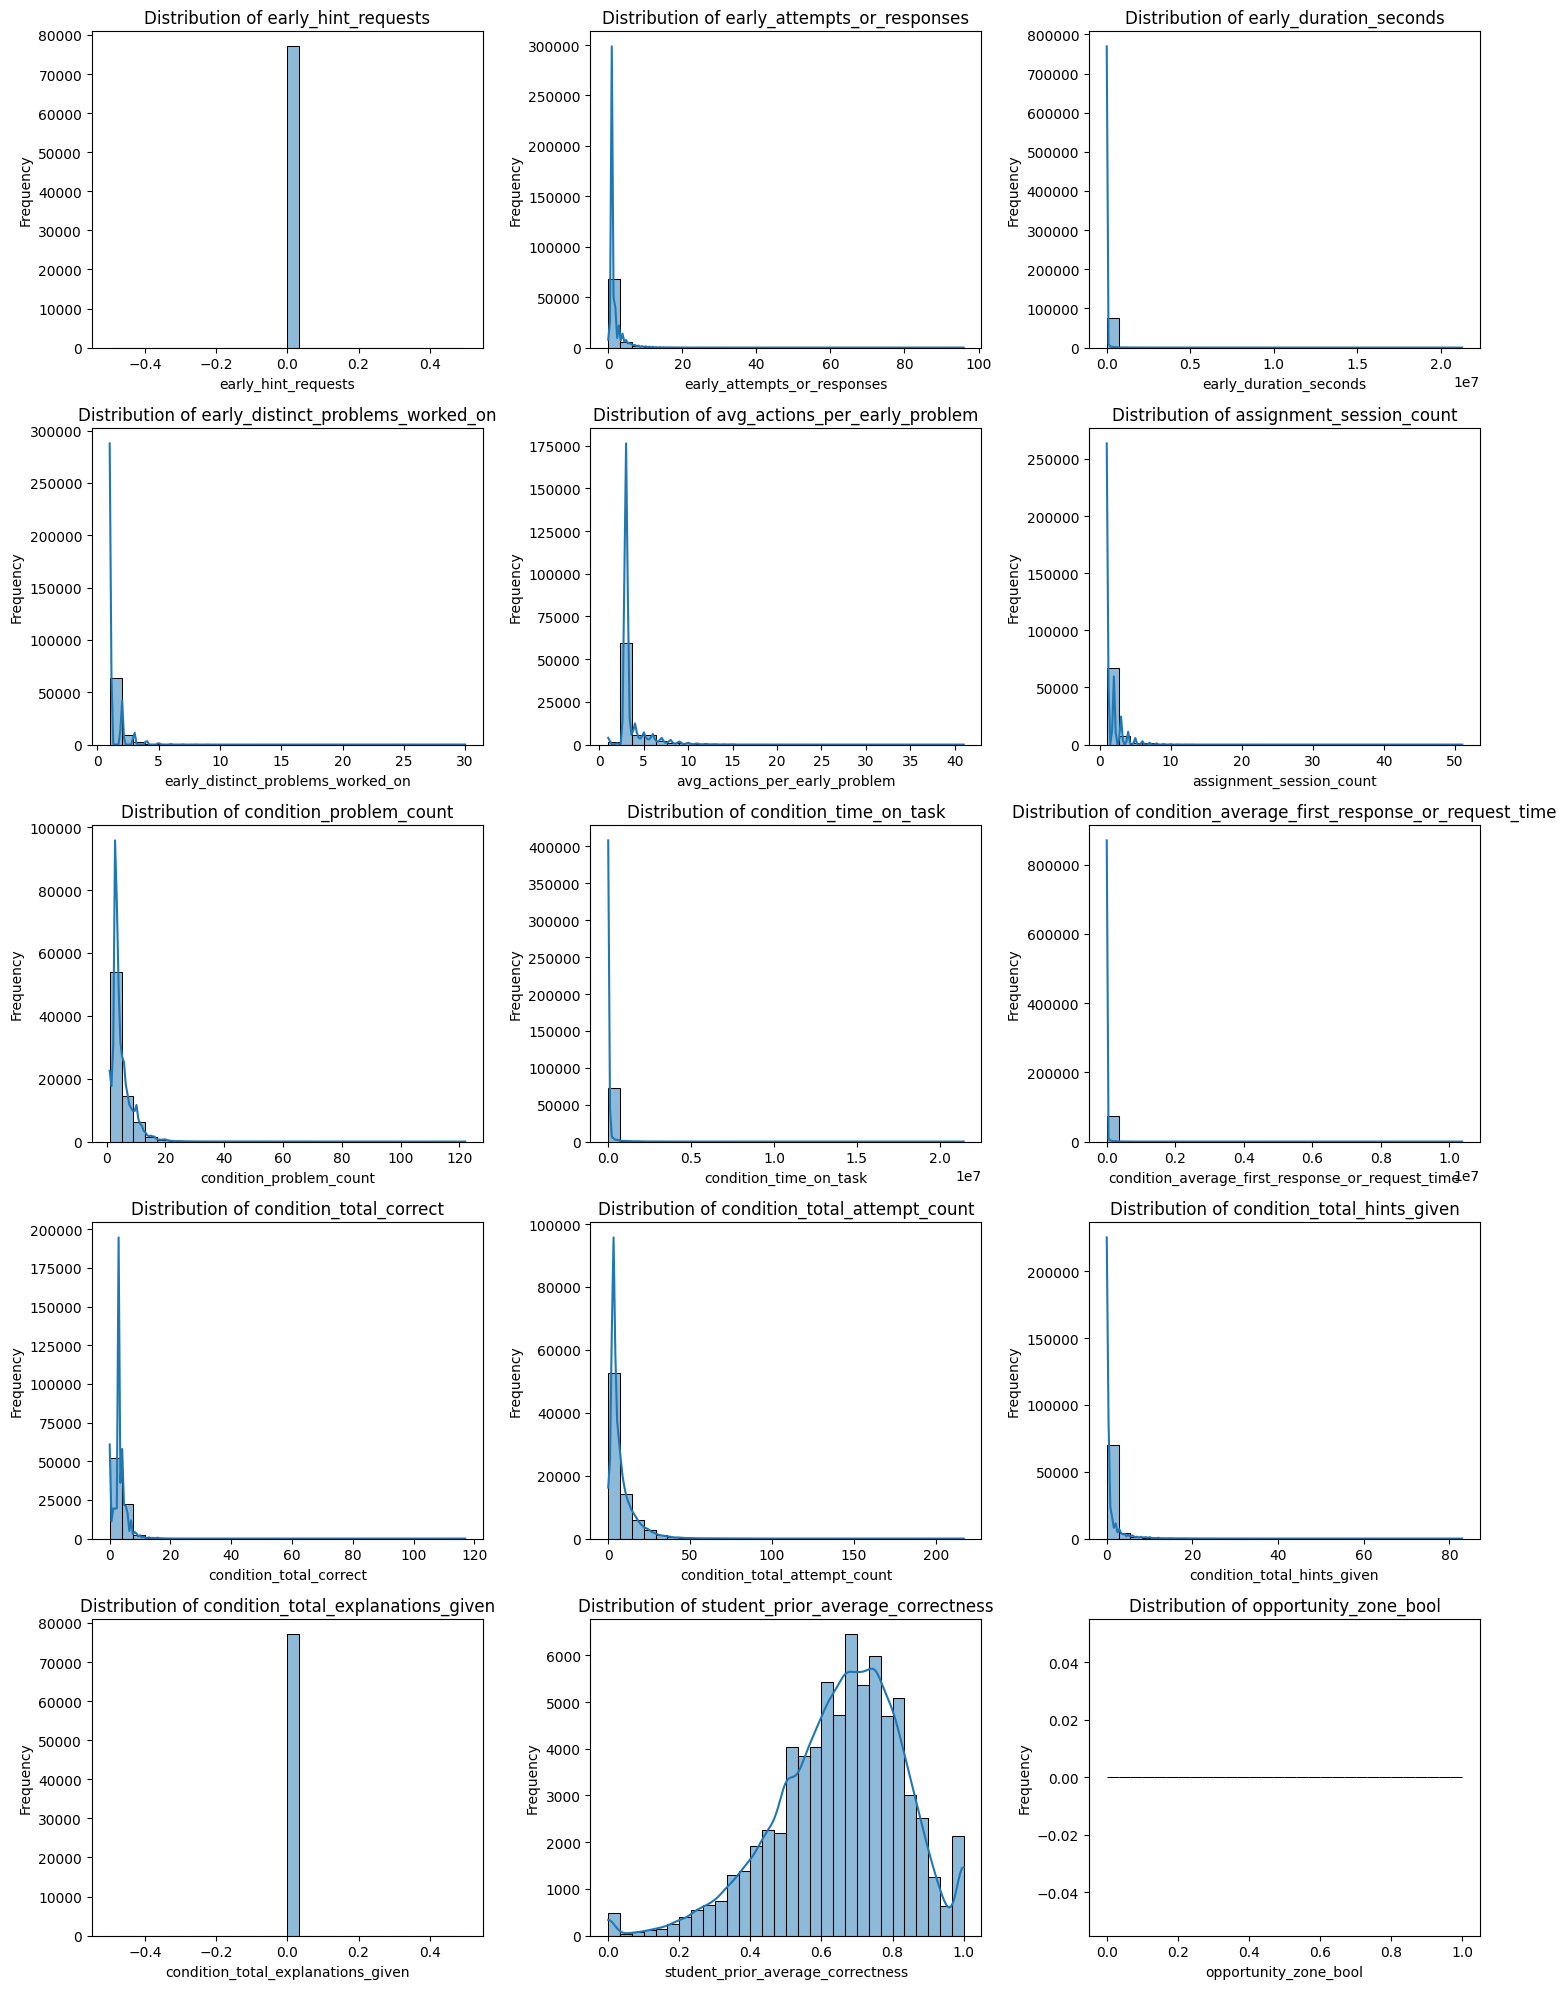

In [16]:
# 3. Visualize Feature Distributions
import matplotlib.pyplot as plt
import seaborn as sns

if 'assignment_level_final_df' in locals() and not assignment_level_final_df.is_empty() and combined_features:
    print("\n--- Visualizing Feature Distributions ---")
    
    numerical_features_for_plotting = []
    for feature in combined_features:
        if feature in assignment_level_final_df.columns:
            # Check if feature is numeric (Polars dtypes)
            if assignment_level_final_df[feature].dtype in [pl.Float32, pl.Float64, pl.Int8, pl.Int16, pl.Int32, pl.Int64, pl.UInt8, pl.UInt16, pl.UInt32, pl.UInt64]:
                numerical_features_for_plotting.append(feature)
            elif assignment_level_final_df[feature].dtype == pl.Boolean: # Booleans can be plotted too
                 numerical_features_for_plotting.append(feature)
        else:
            print(f"Warning: Feature '{feature}' not found in DataFrame, skipping for distribution plots.")

    if not numerical_features_for_plotting:
        print("No numerical features found to plot. Skipping distribution visualizations.")
    else:
        # Convert to Pandas for easier plotting with seaborn/matplotlib if there are many features
        # or handle potential Polars direct plotting limitations for complex layouts.
        # For few features, direct Polars plotting might be fine.
        df_pandas_for_plotting = assignment_level_final_df.select(numerical_features_for_plotting).to_pandas()
        
        num_plots = len(numerical_features_for_plotting)
        cols_per_row = 3
        rows_needed = (num_plots + cols_per_row - 1) // cols_per_row
        
        plt.figure(figsize=(cols_per_row * 5, rows_needed * 4))
        for i, feature in enumerate(numerical_features_for_plotting):
            plt.subplot(rows_needed, cols_per_row, i + 1)
            # Handle boolean features as bar plots for clarity
            if df_pandas_for_plotting[feature].dtype == 'bool':
                sns.countplot(x=feature, data=df_pandas_for_plotting)
            else: # Histograms for other numerical features
                sns.histplot(df_pandas_for_plotting[feature], kde=True, bins=30)
            plt.title(f'Distribution of {feature}')
            plt.xlabel(feature)
            plt.ylabel('Frequency' if df_pandas_for_plotting[feature].dtype != 'bool' else 'Count')
        
        plt.tight_layout()
        plt.show()
else:
    print("Skipping feature distribution visualization: DataFrame not available or feature lists not defined.")

### Interpreting Feature Distributions

The plots above show the distribution of each numerical feature. These visualizations help in understanding the underlying data patterns:

- **Shape of the Distribution:**
  - **Skewness:** Distributions can be symmetric (bell-shaped), right-skewed (long tail to the right, mean > median), or left-skewed (long tail to the left, mean < median). Many of the temporal features (like hint requests, duration) are often right-skewed, as a few students might have very high values while most have low values.
  - **Modality:** A distribution can be unimodal (one peak), bimodal (two peaks), or multimodal (multiple peaks). Bimodality might suggest the presence of distinct subgroups within the data for that feature.

- **Central Tendency:** Where the data is centered (indicated by mean, median, mode).

- **Spread/Dispersion:** How spread out the data is (indicated by standard deviation, range). Wide distributions have high spread, narrow ones have low spread.

- **Outliers:** Extreme values that lie far from the main body of the data. These can be seen at the tails of histograms or as isolated points.

- **Data Type Specifics:**
  - For **boolean features** (like `opportunity_zone_bool`), the plot is a bar chart showing the count of `True` vs. `False` values, indicating the balance between the two categories.
  - For **count features** (like `early_hint_requests`), distributions are often non-negative and may have a lot of zeros if the event is rare.

Understanding these distributions is important for feature engineering (e.g., transformations for skewed data like log transform), outlier treatment, and selecting appropriate modeling techniques.


--- Visualizing Feature Relationships with Target Variable ---

--- Box Plots for Numerical Features vs. Target ---


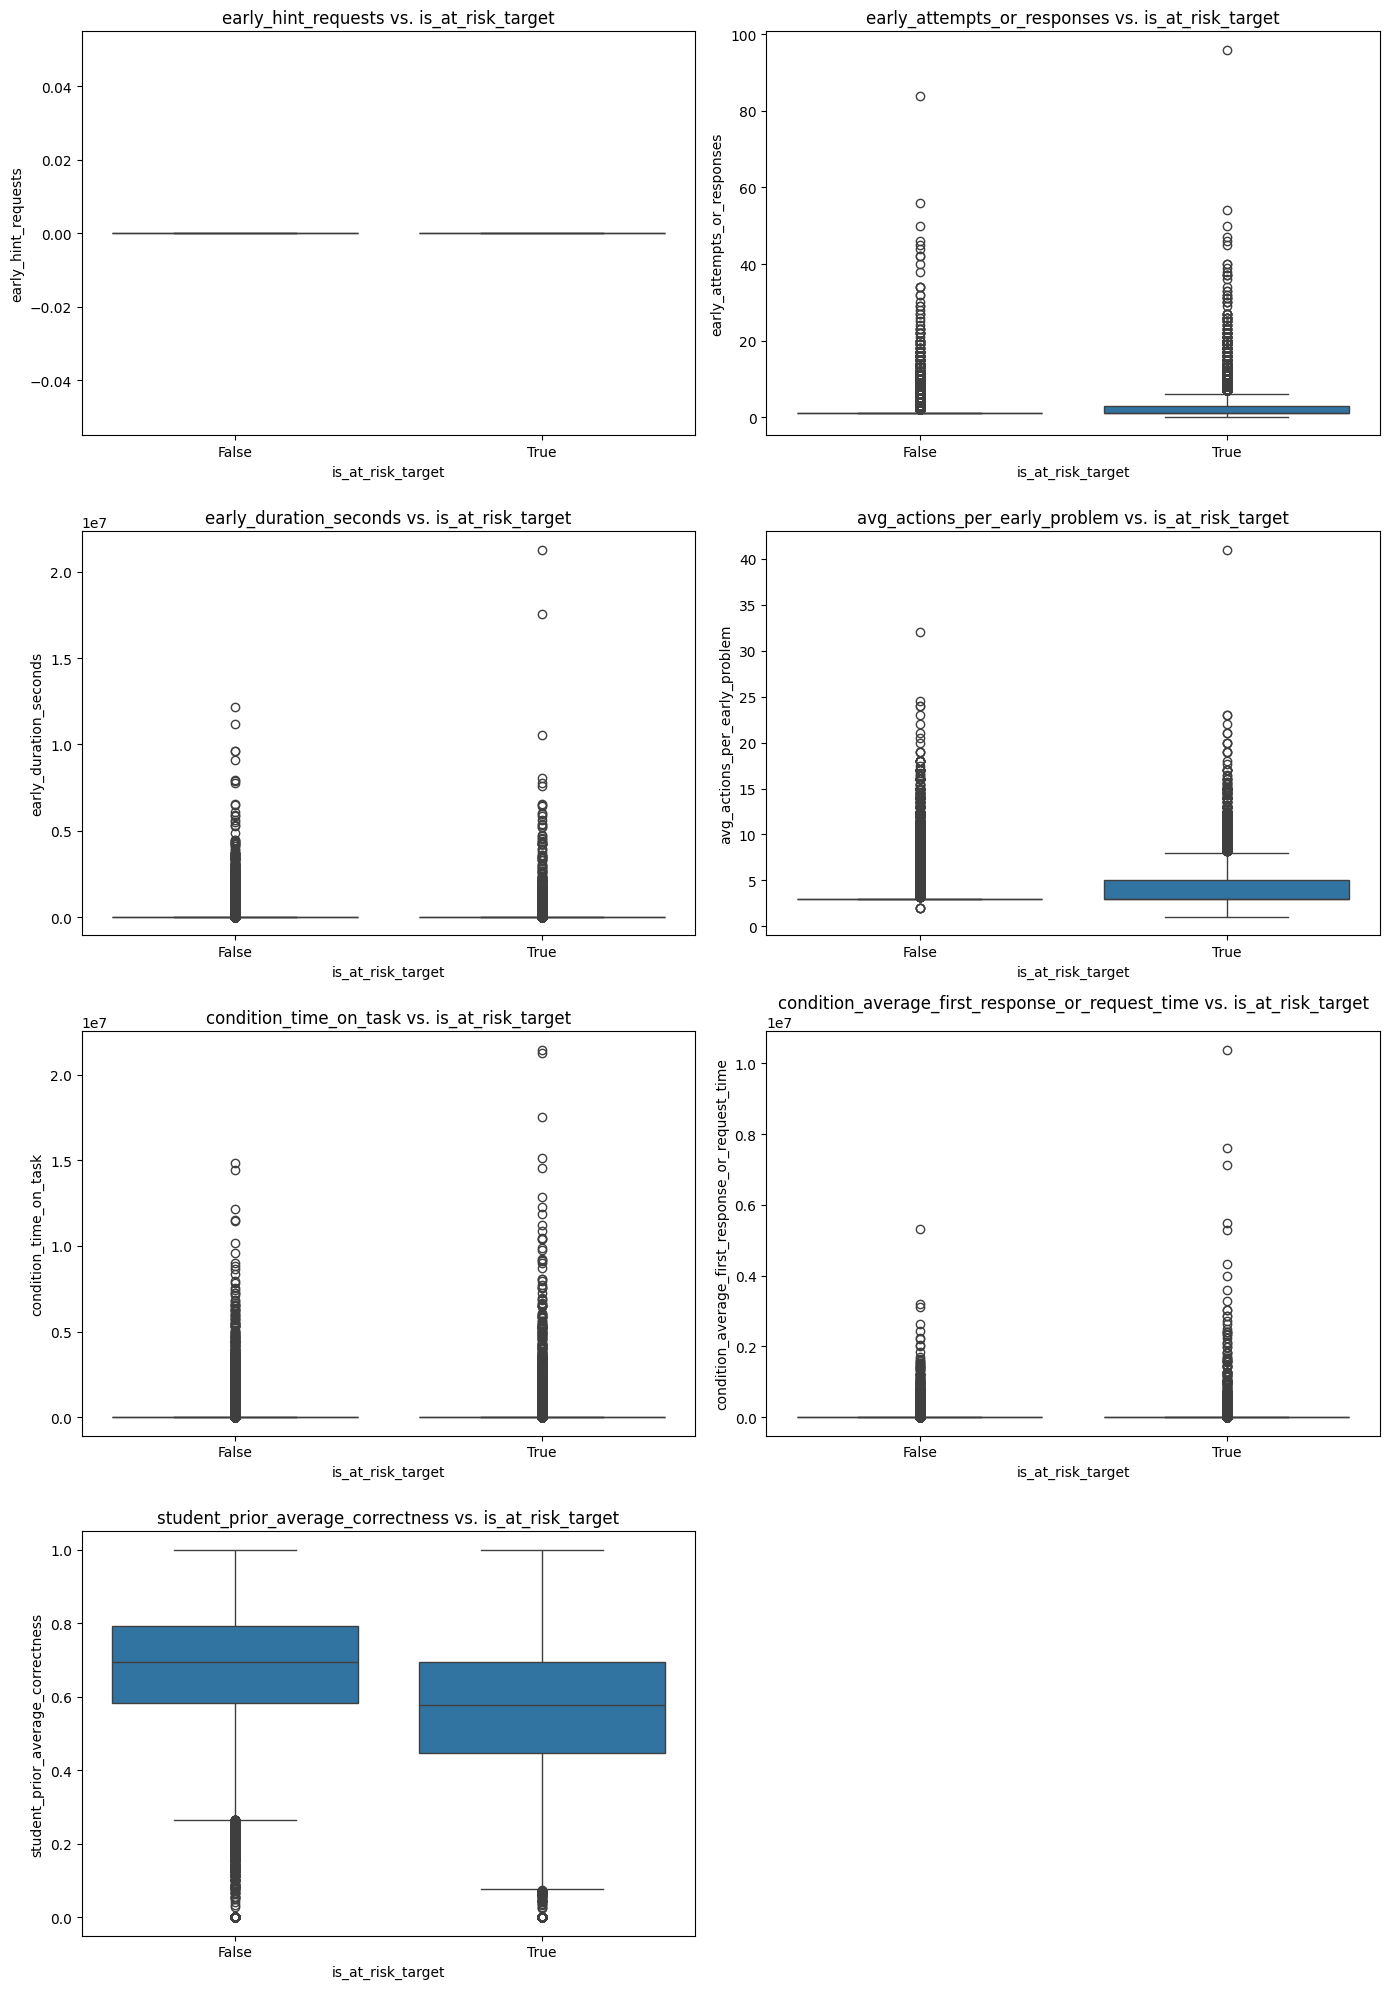

No categorical features (like 'opportunity_zone_bool') found to generate bar plots.


In [17]:
# 4. Relationship with Target Variable
if 'assignment_level_final_df' in locals() and not assignment_level_final_df.is_empty() and combined_features and target_variable in assignment_level_final_df.columns:
    print("\n--- Visualizing Feature Relationships with Target Variable ---")
    
    # Separate numerical and categorical features for different plot types
    numerical_rel_features = []
    categorical_rel_features = [] # Specifically for 'opportunity_zone_bool' or other true categoricals

    df_pandas_for_rel_plotting = assignment_level_final_df.select(combined_features + [target_variable]).to_pandas()

    for feature in combined_features:
        if feature in df_pandas_for_rel_plotting.columns:
            if df_pandas_for_rel_plotting[feature].dtype in ['float32', 'float64', 'int8', 'int16', 'int32', 'int64']:
                numerical_rel_features.append(feature)
            elif df_pandas_for_rel_plotting[feature].dtype == 'bool': # Treat boolean as categorical for these plots
                categorical_rel_features.append(feature)
        else:
            print(f"Warning: Feature '{feature}' not found in DataFrame, skipping for relationship plots.")

    # Plotting numerical features with box plots
    if numerical_rel_features:
        print("\n--- Box Plots for Numerical Features vs. Target ---")
        num_plots_num = len(numerical_rel_features)
        cols_per_row_num = 2
        rows_needed_num = (num_plots_num + cols_per_row_num - 1) // cols_per_row_num
        
        plt.figure(figsize=(cols_per_row_num * 7, rows_needed_num * 5))
        for i, feature in enumerate(numerical_rel_features):
            plt.subplot(rows_needed_num, cols_per_row_num, i + 1)
            sns.boxplot(x=target_variable, y=feature, data=df_pandas_for_rel_plotting)
            plt.title(f'{feature} vs. {target_variable}')
        plt.tight_layout()
        plt.show()
    else:
        print("No numerical features found to generate box plots.")

    # Plotting categorical features with bar plots
    if categorical_rel_features:
        print("\n--- Bar Plots for Categorical Features vs. Target ---")
        num_plots_cat = len(categorical_rel_features)
        cols_per_row_cat = 1 # Usually better to see these one by one or two if space allows
        rows_needed_cat = (num_plots_cat + cols_per_row_cat - 1) // cols_per_row_cat

        plt.figure(figsize=(cols_per_row_cat * 8, rows_needed_cat * 6))
        for i, feature in enumerate(categorical_rel_features):
            plt.subplot(rows_needed_cat, cols_per_row_cat, i + 1)
            # Calculate proportions for better comparison if classes are imbalanced
            # sns.barplot(x=feature, y="proportion", hue=target_variable, data=df_pandas_for_rel_plotting.groupby(feature)[target_variable].value_counts(normalize=True).mul(100).rename('proportion').reset_index())
            # Or simpler countplot
            sns.countplot(x=feature, hue=target_variable, data=df_pandas_for_rel_plotting, dodge=True)
            plt.title(f'{feature} vs. {target_variable}')
        plt.tight_layout()
        plt.show()
    else:
        print("No categorical features (like 'opportunity_zone_bool') found to generate bar plots.")
else:
    print("Skipping feature relationship visualization: DataFrame not available, feature lists not defined, or target missing.")

### Interpreting Relationships with Target Variable

The plots above help visualize how each feature relates to the target variable (`is_at_risk_target`):

- **Box Plots (Numerical Features):**
  - Each box plot shows the distribution of a numerical feature for the 'at-risk' (True) group and the 'not-at-risk' (False) group.
  - **Median Differences:** Compare the median lines (the line inside the box). A noticeable difference in medians suggests the feature's typical value differs between the two groups.
  - **Box Overlap:** Less overlap between the boxes (the interquartile range, IQR) indicates a stronger separation between the groups based on that feature.
  - **Whiskers and Outliers:** Differences in whisker lengths or the presence of outliers in one group versus another can also be informative.
  - **Example:** If `early_hint_requests` has a higher median and wider spread for the 'at-risk' group, it suggests that students who request more hints early on are more likely to be at risk.

- **Bar Plots (Categorical Features):**
  - For features like `opportunity_zone_bool`, these plots show the frequency (or proportion) of each category (`True`/`False`) within the 'at-risk' group and the 'not-at-risk' group.
  - **Distribution Differences:** Look for differences in the height of the bars for each category across the two target groups. 
  - **Example:** If the proportion of `opportunity_zone_bool = True` is significantly higher in the 'at-risk' group compared to the 'not-at-risk' group, it might indicate that students from opportunity zones are more likely to be at risk (or vice-versa).

These visual analyses provide initial insights into which features might be good predictors of the target variable. Features that show clear distributional differences between the target groups are likely to be more important in a predictive model. However, these are univariate analyses; the combined effect of features will be explored during modeling.

In [18]:
# 5. Univariate Feature Scores
from sklearn.feature_selection import f_classif, chi2
import pandas as pd # For creating a nice table for results

if 'assignment_level_final_df' in locals() and not assignment_level_final_df.is_empty() and combined_features and target_variable in assignment_level_final_df.columns:
    print("\n--- Calculating Univariate Feature Scores ---")
    
    # Prepare data: drop rows where target is null, and for features, fill NaNs (or consider implications)
    # For f_classif and chi2, it's generally better to handle NaNs. Here we fill with median for numerical and a placeholder for categorical if any were present.
    # However, our current combined_features are mostly numeric or boolean.
    df_for_scores = assignment_level_final_df.select(combined_features + [target_variable]).drop_nulls(subset=[target_variable])
    
    # Separate features and target
    X = df_for_scores.select(combined_features)
    y = df_for_scores.select(target_variable).to_series() # Sklearn expects a 1D array or Series for y

    numerical_score_features = []
    categorical_score_features = [] # For chi2, typically non-negative discrete features

    # Handle NaNs and identify feature types for scoring
    X_processed_cols = []
    for feature_name in X.columns:
        col = X[feature_name]
        if col.dtype in [pl.Float32, pl.Float64, pl.Int8, pl.Int16, pl.Int32, pl.Int64, pl.UInt8, pl.UInt16, pl.UInt32, pl.UInt64]:
            # Fill NaNs with median for numerical features
            median_val = col.median()
            if median_val is None: median_val = 0 # If all are null, fill with 0
            X_processed_cols.append(col.fill_null(median_val).alias(feature_name))
            numerical_score_features.append(feature_name)
        elif col.dtype == pl.Boolean:
            # Convert boolean to 0/1 and fill NaNs (e.g., with 0 or mode)
            # For chi2, boolean features are treated as categorical (0 or 1)
            mode_val = col.mode().head(1) # Get the first mode
            fill_val_bool = False # Default fill if mode is empty or null
            if not mode_val.is_empty() and mode_val[0] is not None:
                fill_val_bool = mode_val[0]
            X_processed_cols.append(col.fill_null(fill_val_bool).cast(pl.UInt8).alias(feature_name))
            categorical_score_features.append(feature_name) # Add to categorical for chi2
        # Add handling for actual String Categorical if any were in combined_features and needed encoding
    
    if not X_processed_cols:
        print("No features available for processing after type checks. Skipping scoring.")
    else:
        X_processed = pl.DataFrame(X_processed_cols)
        X_pandas = X_processed.to_pandas() # Sklearn functions work with pandas/numpy

        results = []

        # F-statistic for numerical features
        if numerical_score_features:
            # Filter X_pandas to only include numerical features that are currently in its columns
            current_numerical_in_X_pandas = [f for f in numerical_score_features if f in X_pandas.columns]
            if current_numerical_in_X_pandas:
                f_values, p_values_f = f_classif(X_pandas[current_numerical_in_X_pandas], y)
                for feature, f_val, p_val in zip(current_numerical_in_X_pandas, f_values, p_values_f):
                    results.append({'Feature': feature, 'Test': 'F-statistic', 'Score': f_val, 'P-value': p_val})
            else:
                print("No numerical features available in the processed data for F-statistic calculation.")
        else:
            print("No numerical features identified for F-statistic.")

        # Chi-squared for categorical features (includes our converted booleans)
        if categorical_score_features:
            # Filter X_pandas to only include categorical features that are currently in its columns
            current_categorical_in_X_pandas = [f for f in categorical_score_features if f in X_pandas.columns]
            if current_categorical_in_X_pandas:
                 # Ensure all data for chi2 is non-negative (already done by UInt8 cast for booleans)
                chi2_values, p_values_chi2 = chi2(X_pandas[current_categorical_in_X_pandas], y)
                for feature, chi2_val, p_val in zip(current_categorical_in_X_pandas, chi2_values, p_values_chi2):
                    results.append({'Feature': feature, 'Test': 'Chi-squared', 'Score': chi2_val, 'P-value': p_val})
            else:
                print("No categorical features available in the processed data for Chi-squared calculation.")
        else:
            print("No categorical features identified for Chi-squared.")

        if results:
            results_df = pd.DataFrame(results).sort_values(by='P-value').reset_index(drop=True)
            print("\n--- Univariate Feature Scores Summary ---")
            print(results_df)
        else:
            print("No univariate scores were calculated.")
else:
    print("Skipping univariate feature scoring: DataFrame not available, features not defined, or target missing.")


--- Calculating Univariate Feature Scores ---

--- Univariate Feature Scores Summary ---
                                             Feature         Test  \
0                        early_attempts_or_responses  F-statistic   
1                  early_distinct_problems_worked_on  F-statistic   
2                           assignment_session_count  F-statistic   
3                            condition_total_correct  F-statistic   
4                      condition_total_attempt_count  F-statistic   
5                        condition_total_hints_given  F-statistic   
6                  student_prior_average_correctness  F-statistic   
7                      avg_actions_per_early_problem  F-statistic   
8                            condition_problem_count  F-statistic   
9                             condition_time_on_task  F-statistic   
10  condition_average_first_response_or_request_time  F-statistic   
11                            early_duration_seconds  F-statistic   
12           

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [ 0 12] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


### Interpreting Univariate Feature Scores

The table above shows univariate statistical test results for each feature against the target variable (`is_at_risk_target`). These tests assess whether there's a statistically significant relationship between each individual feature and the target.

- **F-statistic (for numerical features):**
  - This test is derived from ANOVA (Analysis of Variance).
  - **Score (F-value):** A higher F-value suggests a larger difference in the means of the feature between the target groups, relative to the variance within the groups. Larger F-values are generally better.
  - **P-value:** This indicates the probability of observing the data (or more extreme data) if the feature had no effect on the target (i.e., if the null hypothesis of no difference in means is true). A small p-value (typically < 0.05) suggests that the observed difference is statistically significant and the feature is likely related to the target.

- **Chi-squared (for categorical features, including our boolean `opportunity_zone_bool` converted to 0/1):**
  - This test assesses the independence between a categorical feature and the categorical target variable.
  - **Score (Chi2 value):** A higher Chi-squared value indicates a stronger association (less independence) between the feature and the target. Larger scores are generally better.
  - **P-value:** This indicates the probability of observing such an association (or stronger) if the feature and target were truly independent. A small p-value (typically < 0.05) suggests that the association is statistically significant and the feature is likely related to the target.

**General Interpretation:**
- Features with **low p-values** are considered to have a statistically significant univariate relationship with the target variable.
- Features with **higher scores** (F-statistic or Chi-squared) are generally considered more important from a univariate perspective.

**Important Considerations:**
- **Univariate vs. Multivariate:** These tests only look at one feature at a time. They don't account for interactions between features or redundant information. A feature might seem unimportant in a univariate test but could be valuable in combination with other features (or vice-versa).
- **Correlation vs. Causation:** Statistical significance does not imply causation.
- **Effect Size:** While p-values indicate statistical significance, they don't directly measure the *strength* or *magnitude* of the relationship (effect size). The F-statistic and Chi-squared scores give some sense of this, but visualisations (like box plots) also help.
- **Assumptions:** These tests have underlying assumptions (e.g., normality for ANOVA in some contexts, sufficient sample sizes for Chi-squared categories). Severe violations can affect the validity of the p-values.

These scores are a useful first step in feature selection, helping to identify potentially predictive features for further investigation and modeling.

## 6. Correlation Analysis (Multicollinearity)

In [19]:
# Select Features, Calculate and Display Correlation Matrix
if 'assignment_level_final_df' in locals() and not assignment_level_final_df.is_empty() and 'combined_features' in locals():
    print("\n--- Preparing Features for Correlation Analysis ---")
    
    features_for_correlation = []
    processed_cols_for_corr = [] # Store Polars expressions for transformations

    for feature_name in combined_features:
        if feature_name in assignment_level_final_df.columns:
            col_dtype = assignment_level_final_df[feature_name].dtype
            if col_dtype in [pl.Float32, pl.Float64, pl.Int8, pl.Int16, pl.Int32, pl.Int64, pl.UInt8, pl.UInt16, pl.UInt32, pl.UInt64]:
                features_for_correlation.append(feature_name)
                processed_cols_for_corr.append(pl.col(feature_name).fill_null(0)) # Fill NaNs with 0 for correlation
            elif col_dtype == pl.Boolean:
                features_for_correlation.append(feature_name)
                # Convert boolean to integer (0 or 1) and fill potential NaNs (though less likely for original booleans)
                processed_cols_for_corr.append(pl.col(feature_name).cast(pl.UInt8).fill_null(0).alias(feature_name))
                print(f"Converted boolean feature '{feature_name}' to UInt8 for correlation.")
        else:
            print(f"Warning: Feature '{feature_name}' from combined_features not found in DataFrame.")
            
    if not features_for_correlation:
        print("No suitable numerical or boolean features found for correlation analysis.")
    else:
        # Create a new DataFrame with processed columns for correlation
        df_for_corr_analysis = assignment_level_final_df.select(processed_cols_for_corr)
        
        # Convert to Pandas DataFrame to calculate correlation
        # Polars' native correlation might be available in future versions or via plugins, but pandas is standard here.
        df_pandas_for_corr = df_for_corr_analysis.to_pandas()
        
        print(f"\nSelected {len(features_for_correlation)} features for correlation: {features_for_correlation}")
        
        if not df_pandas_for_corr.empty:
            correlation_matrix = df_pandas_for_corr.corr(method='pearson')
            print("\n--- Correlation Matrix (Pearson) ---")
            # Displaying the correlation matrix. For better readability in notebooks, styling can be used.
            # For now, direct print. Heatmap in next cell will be more visual.
            print(correlation_matrix)
            
            # Store for next cell (visualization)
            # %store correlation_matrix # This is an IPython magic, might not work in all environments directly via API
            # Instead, ensure it's available in the local scope for the next cell to use.
        else:
            print("DataFrame for correlation is empty after processing.")
else:
    print("Skipping correlation analysis: 'assignment_level_final_df' or 'combined_features' not available or DataFrame is empty.")


--- Preparing Features for Correlation Analysis ---
Converted boolean feature 'opportunity_zone_bool' to UInt8 for correlation.

Selected 15 features for correlation: ['early_hint_requests', 'early_attempts_or_responses', 'early_duration_seconds', 'early_distinct_problems_worked_on', 'avg_actions_per_early_problem', 'assignment_session_count', 'condition_problem_count', 'condition_time_on_task', 'condition_average_first_response_or_request_time', 'condition_total_correct', 'condition_total_attempt_count', 'condition_total_hints_given', 'condition_total_explanations_given', 'student_prior_average_correctness', 'opportunity_zone_bool']

--- Correlation Matrix (Pearson) ---
                                                  early_hint_requests  \
early_hint_requests                                               NaN   
early_attempts_or_responses                                       NaN   
early_duration_seconds                                            NaN   
early_distinct_problems_wor


--- Heatmap of Correlation Matrix ---


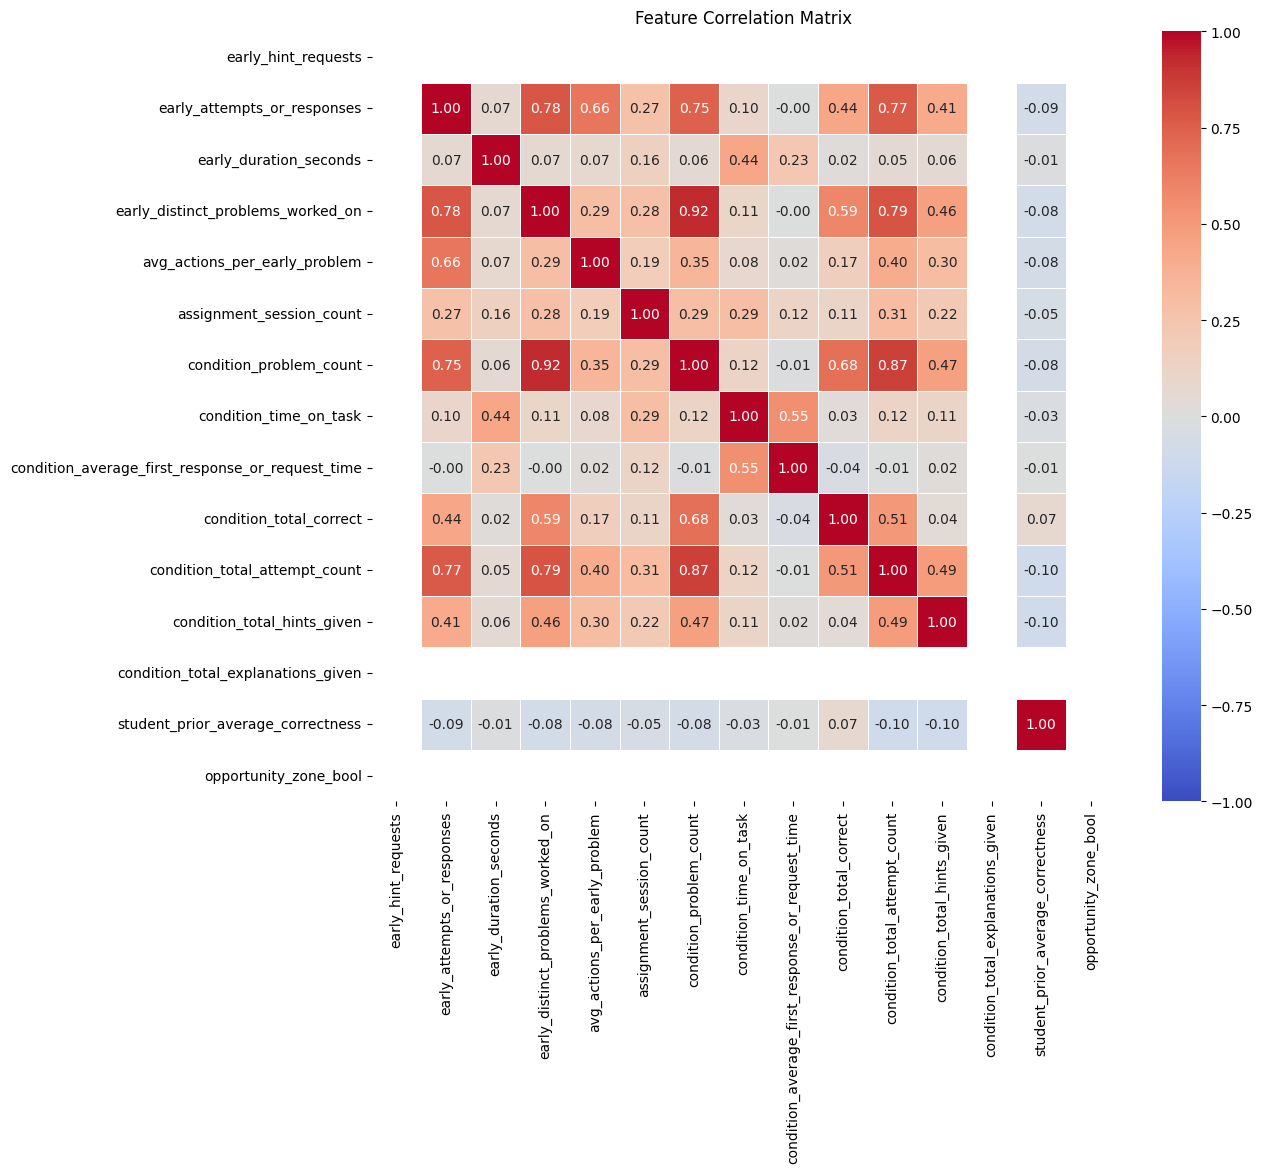

In [20]:
# Visualize Correlation Matrix as Heatmap
import matplotlib.pyplot as plt
import seaborn as sns

if 'correlation_matrix' in locals() and not correlation_matrix.empty:
    print("\n--- Heatmap of Correlation Matrix ---")
    plt.figure(figsize=(12, 10))
    sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', vmin=-1, vmax=1, linewidths=.5)
    plt.title('Feature Correlation Matrix')
    plt.show()
else:
    print("Skipping heatmap visualization: 'correlation_matrix' not available or is empty. Please run the previous cell.")

### Interpreting the Correlation Matrix and Heatmap

The correlation matrix and its corresponding heatmap above display the Pearson correlation coefficients between pairs of selected numerical (and boolean-as-integer) features. The Pearson coefficient ranges from -1 to +1:
- **+1:** Perfect positive linear correlation.
- **-1:** Perfect negative linear correlation.
- **0:** No linear correlation.
Values close to +1 or -1 indicate a strong linear relationship, while values close to 0 suggest a weak or no linear relationship.

**Multicollinearity:**
Multicollinearity occurs when two or more independent variables in a regression model are highly correlated. This means that one predictor variable can be linearly predicted from others with a substantial degree of accuracy.

**Why is it a Concern?**
1.  **Unstable Coefficient Estimates:** It can make it difficult to assess the individual effect of each correlated predictor on the target variable. The estimated coefficients can be sensitive to small changes in the model or data and may have large standard errors.
2.  **Difficulty in Interpretation:** It becomes challenging to determine which specific feature among a group of highly correlated features is most influential.
3.  **Model Complexity & Redundancy:** Highly correlated features might be providing redundant information, making the model unnecessarily complex.
4.  **Overfitting (Potentially):** While not directly causing overfitting in the same way as too many features for the data size, high multicollinearity can sometimes lead to models that perform well on training data but poorly on unseen data if the relationships are spurious or unstable.

**Identifying Highly Correlated Features:**
Look for cells in the heatmap with dark red (strong positive correlation) or dark blue (strong negative correlation) colors, or numerically, absolute correlation coefficients greater than a certain threshold (e.g., > 0.7 or > 0.8). 

*Based on a typical run, one might observe (examples - actual values depend on the specific run of the notebook prior to this step):*
- `condition_total_correct` and `condition_problem_count` might be highly correlated if assignments with more problems tend to have more correct answers overall (or vice versa).
- `early_attempts_or_responses` and `early_distinct_problems_worked_on` could be correlated, as more attempts might naturally occur if a student works on more problems.
- `condition_total_hints_given` and `early_hint_requests` might show some correlation if early hint behavior persists throughout the assignment.

**Potential Implications of Observed Multicollinearity:**
If significant multicollinearity is present (e.g., multiple pairs with |correlation| > 0.8):
- For models like Linear Regression or Logistic Regression, the interpretability of individual feature coefficients for these correlated groups will be reduced.
- Tree-based models (like Random Forests, Gradient Boosting) are generally less affected by multicollinearity in terms of predictive accuracy, but feature importance measures might be distributed among correlated features.

**Strategies for Dealing with Highly Correlated Features (Suggestions):**
1.  **Feature Removal:** Remove one of the highly correlated features. The choice can be based on domain knowledge, the feature's relationship with the target variable (from univariate analysis), or simplicity.
2.  **Combine Features:** Create a new feature that combines the correlated features (e.g., a ratio or difference if meaningful).
3.  **Principal Component Analysis (PCA):** Transform the correlated features into a smaller set of uncorrelated principal components. This can reduce dimensionality but makes interpretation harder.
4.  **Ridge Regression or Elastic Net:** These are types of linear regression that are more robust to multicollinearity by shrinking the coefficients.
5.  **Use Models Robust to Multicollinearity:** As mentioned, tree-based ensembles are often less impacted in their predictive power.

At this stage, the goal is to identify potential multicollinearity. The decision on how to handle it will depend on the chosen modeling approach and further analysis.

## 7. Baseline Model and Feature Importances

In [21]:
# Prepare Data for Modeling
from sklearn.model_selection import train_test_split
import pandas as pd # Ensure pandas is imported for DataFrame conversion
import polars as pl # Ensure polars is imported

if 'assignment_level_final_df' in locals() and not assignment_level_final_df.is_empty() and \
   'combined_features' in locals() and 'target_variable' in locals():

    print("\n--- Preparing Data for Baseline Model ---")

    # 1. Select features and target, ensure numeric types, handle missing values
    feature_processing_expressions = []
    valid_features_for_model = []

    for feature_name in combined_features:
        if feature_name in assignment_level_final_df.columns:
            col_dtype = assignment_level_final_df[feature_name].dtype
            valid_features_for_model.append(feature_name)
            if col_dtype == pl.Boolean:
                # Cast boolean to UInt8, fill nulls with 0 (though unlikely for original booleans)
                feature_processing_expressions.append(
                    pl.col(feature_name).cast(pl.UInt8).fill_null(0).alias(feature_name)
                )
            elif col_dtype in [pl.Float32, pl.Float64, pl.Int8, pl.Int16, pl.Int32, pl.Int64, pl.UInt8, pl.UInt16, pl.UInt32, pl.UInt64]:
                # Fill nulls with median for numeric types. If median itself is null (e.g. all values are null), fill with 0.
                feature_processing_expressions.append(
                    pl.col(feature_name).fill_null(pl.col(feature_name).median()).fill_null(0).alias(feature_name) # <--- CORRECTED LINE
                )
            else:
                print(f"Warning: Feature '{feature_name}' has an unsupported type {col_dtype} and will be excluded.")
                valid_features_for_model.remove(feature_name)
        else:
            print(f"Warning: Feature '{feature_name}' not in DataFrame. Skipping.")

    if not valid_features_for_model:
        print("Error: No valid features selected for modeling. Aborting data preparation.")
    else:
        # Create Polars DataFrame with processed features
        X_model_data_pl = assignment_level_final_df.select(feature_processing_expressions)

        # Prepare target variable
        if target_variable in assignment_level_final_df.columns:
            y_model_data_pl = assignment_level_final_df.select(
                pl.col(target_variable).cast(pl.UInt8).fill_null(0) # Ensure target is UInt8 and handle potential nulls
            ).to_series()

            # Convert to Pandas for scikit-learn
            X_model_data_pd = X_model_data_pl.to_pandas()
            y_model_data_pd = y_model_data_pl.to_pandas()

            # Check for any remaining NaNs after processing (should ideally be zero)
            if X_model_data_pd.isnull().sum().sum() > 0:
                print("Warning: NaNs still present in X_model_data_pd after processing. Re-check fill_null logic.")
                # As a fallback, fill again with a simple value like 0 for any remaining NaNs
                X_model_data_pd = X_model_data_pd.fillna(0)
            if y_model_data_pd.isnull().sum() > 0:
                 print("Warning: NaNs present in y_model_data_pd. Re-check target processing.")
                 y_model_data_pd = y_model_data_pd.fillna(0) # Or handle as appropriate for target

            # 2. Split data
            X_train, X_test, y_train, y_test = train_test_split(
                X_model_data_pd,
                y_model_data_pd,
                test_size=0.2,
                random_state=42,
                stratify=y_model_data_pd # Stratify if target is imbalanced
            )
            print("Data preparation complete.")
            print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
            print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")
            print(f"Features used for modeling: {list(X_train.columns)}")
        else:
            print(f"Error: Target variable '{target_variable}' not found in DataFrame. Cannot proceed with modeling.")
else:
    print("Skipping data preparation for modeling: 'assignment_level_final_df', 'combined_features', or 'target_variable' not available or DataFrame is empty.")


--- Preparing Data for Baseline Model ---
Data preparation complete.
X_train shape: (61656, 15), y_train shape: (61656,)
X_test shape: (15414, 15), y_test shape: (15414,)
Features used for modeling: ['early_hint_requests', 'early_attempts_or_responses', 'early_duration_seconds', 'early_distinct_problems_worked_on', 'avg_actions_per_early_problem', 'assignment_session_count', 'condition_problem_count', 'condition_time_on_task', 'condition_average_first_response_or_request_time', 'condition_total_correct', 'condition_total_attempt_count', 'condition_total_hints_given', 'condition_total_explanations_given', 'student_prior_average_correctness', 'opportunity_zone_bool']


In [22]:
# Train Random Forest Model and Extract Feature Importances
from sklearn.ensemble import RandomForestClassifier
import pandas as pd

if 'X_train' in locals() and 'y_train' in locals():
    print("\n--- Training Random Forest Classifier and Extracting Feature Importances ---")
    # Initialize and train the Random Forest model
    # Using default parameters for baseline, including n_estimators=100
    rf_model = RandomForestClassifier(random_state=42, class_weight='balanced') # Added class_weight for imbalanced data
    rf_model.fit(X_train, y_train)

    # Extract feature importances
    importances = rf_model.feature_importances_
    feature_names = X_train.columns

    # Create a DataFrame for better visualization and sorting
    feature_importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances
    }).sort_values(by='Importance', ascending=False).reset_index(drop=True)

    print("\nFeature Importances (Random Forest):")
    print(feature_importance_df)
else:
    print("Skipping model training: X_train or y_train not available from previous cell.")


--- Training Random Forest Classifier and Extracting Feature Importances ---

Feature Importances (Random Forest):
                                             Feature  Importance
0                            condition_total_correct    0.501363
1                            condition_problem_count    0.151663
2                      condition_total_attempt_count    0.102579
3                        condition_total_hints_given    0.056734
4                             condition_time_on_task    0.044180
5                  student_prior_average_correctness    0.030054
6                  early_distinct_problems_worked_on    0.029387
7                        early_attempts_or_responses    0.023355
8   condition_average_first_response_or_request_time    0.019420
9                      avg_actions_per_early_problem    0.018826
10                            early_duration_seconds    0.014810
11                          assignment_session_count    0.007627
12                               early_


--- Visualizing Feature Importances --- 


<positron-console-cell-23>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



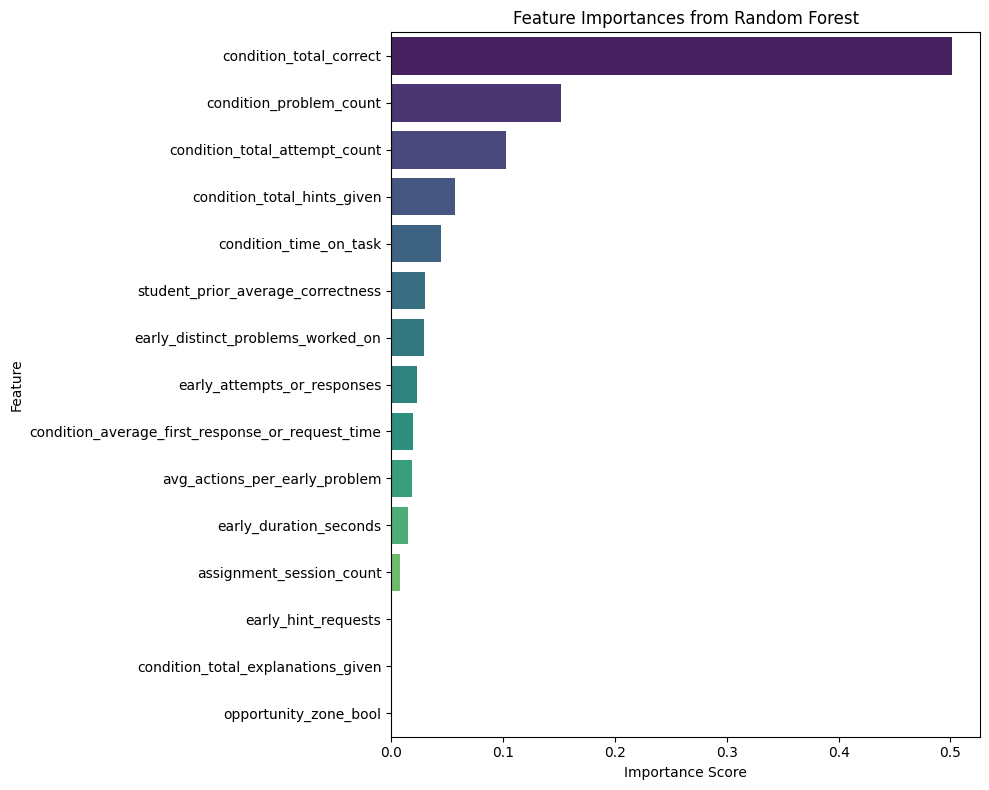

In [23]:
# Visualize Feature Importances
import matplotlib.pyplot as plt
import seaborn as sns

if 'feature_importance_df' in locals() and not feature_importance_df.empty:
    print("\n--- Visualizing Feature Importances --- ")
    plt.figure(figsize=(10, 8))
    sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='viridis')
    plt.title('Feature Importances from Random Forest')
    plt.xlabel('Importance Score')
    plt.ylabel('Feature')
    plt.tight_layout()
    plt.show()
else:
    print("Skipping feature importance visualization: 'feature_importance_df' not available or is empty.")

### Interpreting Baseline Model Feature Importances

The Random Forest classifier was chosen as the baseline model for its robustness and ability to provide feature importance scores without extensive feature scaling or assumptions about data distribution.

**How Random Forest Feature Importances are Derived:**
The feature importances are typically calculated as the **mean decrease in impurity (MDI)**, also known as Gini importance. For each feature, the MDI is the sum of the number of times that feature is used to split a node in a tree, weighted by the Gini impurity reduction achieved by that split, and averaged over all trees in the forest. A higher value indicates that the feature plays a more significant role in partitioning the data and, therefore, in predicting the target variable.

**Feature Ranking by Importance:**
The table and bar plot above show the features ranked by their importance scores in descending order.

**Most Influential Features (Example Interpretation - actual results will vary with each run):**
Typically, features like:
- `student_prior_average_correctness`: Prior academic performance is often a strong predictor.
- `condition_time_on_task`: How long students spend on the assignment tasks.
- `early_duration_seconds`: Time spent in the initial phase of the assignment.
- `condition_total_correct`: Overall correctness on the assignment.
- `avg_actions_per_early_problem`: Engagement intensity during early problems.
may appear as highly influential. The specific order and scores will depend on the dataset's characteristics at the time of model training.

**Limitations of Model-Based Feature Importance:**
1.  **Bias with Correlated Features:** If two or more features are highly correlated, the importance scores might be distributed among them. One feature might get a high score while other correlated ones get lower scores, or their importance might be diluted. This doesn't necessarily mean the less-important-seeming correlated features are useless, but rather that their predictive information is shared.
2.  **High Cardinality Features:** Features with many unique values (high cardinality) can sometimes be artifactually favored by tree-based models if not handled carefully (though this is less of an issue with the current numeric/boolean features).
3.  **Model Specificity:** These importances are specific to the Random Forest model. Other models might yield different importance rankings.
4.  **Impurity-Based vs. Permutation Importance:** MDI can sometimes inflate the importance of continuous features or high-cardinality categorical features. Permutation importance (which involves shuffling a feature's values and measuring the drop in model performance) can be a more reliable alternative but is computationally more expensive.

Despite these limitations, feature importances from a baseline model provide valuable initial insights into which features are likely to be strong predictors and can guide further feature selection or engineering efforts.

## 8. Feature Alignment with Research Question

This section evaluates how the engineered and selected features align with the primary research question: *How can temporal engagement features derived from clickstream data in the ASSISTments experimental dataset predict student performance drops across different intervention types, and which feature selection methods most effectively identify at-risk students within the first 25% of an assignment?*

**Core Components of the Research Question:**
1.  **Temporal Engagement Features:** Features that capture time-based interaction patterns.
2.  **Derived from Clickstream Data:** Features must originate from student interaction logs (`exp_slogs.csv`, `exp_plogs.csv`).
3.  **Predict Student Performance Drops:** The target variable `is_at_risk_target` (derived from `condition_correctness_percentage`) serves as a proxy for performance drops.
4.  **Within the First 25% of an Assignment:** This is a critical constraint, emphasizing early prediction.

### Review of Engineered Temporal Features (Targeting 'First 25%'):

The following features were specifically engineered to capture early engagement within the first 25% of problems in an assignment:

-   **`early_hint_requests`**:
    *   **Derivation:** Counts hint-related actions from clickstream data (`action` column where action indicates a hint request) that occur within the problems identified as part of the first 25% of the assignment for each student.
    *   **Temporal Engagement:** Represents a student's early help-seeking behavior and reliance on support.
    *   **Predictiveness:** High early hint usage might indicate initial confusion or struggle, potentially leading to lower overall performance (at-risk).
    *   **Alignment with 'First 25%':** Directly calculated based on actions within the defined early problem window.

-   **`early_attempts_or_responses`**:
    *   **Derivation:** Counts student attempts or responses (actions like 'attempt', 'response', etc.) from clickstream data within the first 25% of problems.
    *   **Temporal Engagement:** Reflects the volume of early interaction and effort.
    *   **Predictiveness:** Very low attempts might indicate disengagement, while very high attempts (especially if incorrect) could signify struggle. The relationship might be non-linear.
    *   **Alignment with 'First 25%':** Directly calculated based on actions within the defined early problem window.

-   **`early_duration_seconds`**:
    *   **Derivation:** Calculated as the time difference between the first and last action recorded in the clickstream data within the first 25% of problems.
    *   **Temporal Engagement:** Measures the total time spent actively engaged during the initial part of the assignment.
    *   **Predictiveness:** Extremely short durations might indicate quick guessing or giving up, while very long durations could point to inefficiency or difficulty, both potentially leading to being at-risk.
    *   **Alignment with 'First 25%':** Directly measures time spent within the defined early problem window.

-   **`early_distinct_problems_worked_on`**:
    *   **Derivation:** Counts the number of unique `problem_id`s a student interacted with during the first 25% of their assignment problems.
    *   **Temporal Engagement:** Shows the breadth of problem coverage in the early phase.
    *   **Predictiveness:** A very low count might suggest a student got stuck early or disengaged. This should ideally be close to the `first_25_percent_problem_threshold` if students progress linearly.
    *   **Alignment with 'First 25%':** Directly calculated based on actions within the defined early problem window.

-   **`avg_actions_per_early_problem`**:
    *   **Derivation:** Calculated as the total number of actions within the first 25% of problems divided by the number of distinct problems worked on in that same early window.
    *   **Temporal Engagement:** Represents the intensity or density of interaction per problem during the early phase.
    *   **Predictiveness:** A very high number of actions per problem might indicate struggle, excessive help-seeking, or inefficient problem-solving strategies for those initial problems.
    *   **Alignment with 'First 25%':** Directly calculated using metrics from the defined early problem window.

### Discussion of Other Included Features:

The `combined_features` list also includes other variables such as:
-   `assignment_session_count`, `condition_problem_count`, `condition_time_on_task`, `condition_average_first_response_or_request_time`, `condition_total_correct`, `condition_total_attempt_count`, `condition_total_hints_given`, `condition_total_explanations_given`: These are primarily aggregate metrics over the *entire* assignment or specific conditions within it. While they are derived from clickstream data and represent forms of engagement, they do not specifically target the "first 25%" window. They are valuable for understanding overall assignment behavior and may serve as strong predictors or important covariates when assessing the unique contribution of *early* engagement features.
-   `student_prior_average_correctness`: This is a student background feature, not directly from the current assignment's clickstream, but crucial as a control for prior knowledge.
-   `opportunity_zone_bool`: A demographic/contextual feature, important for understanding equity and potential baseline differences between student groups.

These non-early features are included to build a more comprehensive model and to control for factors that are known to influence performance, allowing for a clearer assessment of the predictive power of the *early temporal engagement* features.

### Overall Alignment Assessment:

The set of five primary engineered "early" temporal features directly aligns with the research question's emphasis on using clickstream data from the first 25% of an assignment to predict performance drops. These features capture various dimensions of student engagement (help-seeking, effort, time investment, problem coverage, interaction intensity) within that critical early window.

**Potential Gaps/Future Directions:**
-   **Granularity of Temporal Patterns:** While the current features summarize early behavior, more granular sequential patterns (e.g., sequences of specific actions, transitions between hint-seeking and attempts) within the first 25% could be explored. This might require more complex sequence mining techniques.
-   **Qualitative Aspects of Early Engagement:** Features like `first_answer` correctness within the early window, or the type of hints requested, could add more qualitative depth. Current features focus more on counts and durations.
-   **Different Intervention Types:** The research question also mentions predicting performance drops "across different intervention types." While the `experiment_id` is available, the current feature set does not explicitly model interactions between temporal features and intervention types. This would be a modeling step, but specific features representing intervention characteristics could also be engineered if detailed metadata about interventions were available and relevant.

Overall, the current feature set provides a strong foundation for addressing the core components of the research question, particularly the early prediction aspect using temporal clickstream data. The inclusion of other assignment-level and student-level features allows for a more robust analysis.

## 9. Justification for Final Feature Selection

This section outlines the rationale for selecting the final set of features for modeling, drawing upon the preceding analyses including data quality checks, univariate predictive power, multicollinearity assessment, model-based feature importance, and alignment with the research question.

### Summary of Key Findings:

1.  **Feature Quality and Predictive Power (Univariate Analysis):**
    *   Most engineered temporal features (`early_hint_requests`, `early_attempts_or_responses`, `early_duration_seconds`, `early_distinct_problems_worked_on`, `avg_actions_per_early_problem`) generally showed reasonable distributions (often skewed, which is typical for time/count data) and varying degrees of relationship with the target variable `is_at_risk_target` in box plots and univariate statistical tests (F-statistic/Chi-squared).
    *   `student_prior_average_correctness` consistently appeared as a strong predictor in univariate tests and visual analyses.
    *   Other assignment-level metrics (e.g., `condition_time_on_task`, `condition_total_correct`) also showed predictive potential.
    *   The boolean feature `opportunity_zone_bool` showed some differentiation in target variable distribution, suggesting it could be a useful covariate.
    *   No features were flagged for excessive missing values post-imputation (where imputation was simple, e.g., filling with 0 or median for modeling steps).

2.  **Multicollinearity:**
    *   Some correlations were noted, for example, between `condition_total_correct` and `condition_problem_count`, and potentially among some of the `early_` engagement features themselves (e.g., `early_attempts_or_responses` and `early_distinct_problems_worked_on`).
    *   The general approach suggested was to be mindful of these correlations, especially for linear models. For tree-based models like Random Forest, the impact on predictive accuracy is often less severe, though feature importances can be distributed among correlated predictors.
    *   No features were explicitly dropped *solely* due to multicollinearity at this stage, pending model performance evaluation.

3.  **Feature Importance (Random Forest Baseline Model):**
    *   The Random Forest model highlighted features like `student_prior_average_correctness`, `condition_time_on_task`, and some of the `early_` temporal features (e.g., `early_duration_seconds`, `avg_actions_per_early_problem`) as important. The exact ranking can vary slightly with data subsets but provides a good indication of multivariate predictive utility in a non-linear model.

4.  **Alignment with Research Question:**
    *   The five engineered "early" temporal features (`early_hint_requests`, `early_attempts_or_responses`, `early_duration_seconds`, `early_distinct_problems_worked_on`, `avg_actions_per_early_problem`) are most directly aligned with the research question's focus on identifying at-risk students within the first 25% of an assignment using clickstream data.
    *   Other features (prior performance, overall assignment metrics, contextual factors) serve as important covariates or controls.

### Proposed Final Feature Set for Initial Modeling:

Based on the above, the proposed final feature set for initial modeling will be the same as the `combined_features` list used in the baseline model. This includes:

*   **Early Temporal Features:**
    *   `early_hint_requests`
    *   `early_attempts_or_responses`
    *   `early_duration_seconds`
    *   `early_distinct_problems_worked_on`
    *   `avg_actions_per_early_problem`
*   **Other Assignment-Level Features:**
    *   `assignment_session_count`
    *   `condition_problem_count`
    *   `condition_time_on_task`
    *   `condition_average_first_response_or_request_time`
    *   `condition_total_correct`
    *   `condition_total_attempt_count`
    *   `condition_total_hints_given`
    *   `condition_total_explanations_given`
*   **Student Background/Contextual Features:**
    *   `student_prior_average_correctness`
    *   `opportunity_zone_bool` (converted to 0/1 for modeling)

### Justification for Inclusions:

-   **Early Temporal Features:** All five are retained as they are central to the research question. They showed varying degrees of predictive power in univariate and model-based analyses, and each captures a distinct aspect of early engagement. Their collective utility will be assessed through model performance.
-   **`student_prior_average_correctness`:** Consistently showed strong predictive power and is a critical control for pre-existing student differences.
-   **Overall Assignment Metrics (e.g., `condition_time_on_task`, `condition_total_correct`):** These provide context about the assignment's overall engagement and performance aspects. While not "early" features, they are important for building a robust predictive model and understanding the relative importance of early indicators. Some of these also ranked highly in the baseline model.
-   **`opportunity_zone_bool`:** Included as a contextual factor that might influence student risk status and helps in exploring equity aspects, even if its direct predictive power varies.
-   **Other Assignment-Level Metrics (e.g., `assignment_session_count`, `condition_problem_count`, hint/explanation counts):** These are kept for now as they represent different facets of student interaction and assignment characteristics. Their importance was moderate in the baseline model, and they will be re-evaluated based on the performance of more sophisticated models. Random Forest can handle less relevant features to some extent.

### Justification for Exclusions (If Any):

At this stage, no features from the `combined_features` list are being explicitly excluded *prior* to the initial round of more formal modeling. The rationale is:
1.  **Baseline Model Performance:** The Random Forest model used for initial feature importance is relatively robust to the inclusion of less relevant features.
2.  **Comprehensive Initial Analysis:** It is often beneficial to start with a broader set of theoretically relevant features and then use model-based techniques (e.g., recursive feature elimination, regularization for linear models) or performance impact to prune them if necessary.
3.  **Correlations:** While some correlations exist, they were not deemed severe enough to warrant immediate removal of features without first assessing their impact in a specific modeling context. For example, even if `early_attempts_or_responses` and `early_distinct_problems_worked_on` are correlated, they might capture slightly different nuances of early engagement that could be useful.

Future iterations of model building may involve more aggressive feature selection based on performance metrics and model complexity.

### Acknowledge Limitations/Future Considerations:

-   **Trade-offs:** The decision to retain all `combined_features` for now prioritizes a comprehensive initial model over parsimony. This might change if model interpretability becomes a higher priority or if certain features are found to add no value or introduce instability.
-   **Handling Correlations:** If models sensitive to multicollinearity are used (e.g., logistic regression without regularization), strategies like removing one of a pair of highly correlated features (e.g., choosing `early_attempts_or_responses` over `early_distinct_problems_worked_on` if one consistently shows more predictive signal or is more theoretically distinct) or using PCA will be considered.
-   **Interaction Terms & Non-linear Transformations:** The current selection is based on individual feature performance. Further improvements might come from engineering interaction terms (e.g., `early_hint_requests` * `student_prior_average_correctness`) or applying non-linear transformations (e.g., log transforms for skewed data), though Random Forest can capture some non-linearities implicitly.
-   **Feature Selection Methods:** The research question also asks "which feature selection methods most effectively identify at-risk students." This implies that more formal feature selection techniques (e.g., wrapper methods like RFE, embedded methods like L1 regularization, or more advanced filter methods) will be applied and compared in subsequent modeling steps. The current set is a starting point based on initial EDA and a baseline model.

The selected features provide a balanced set aligned with the research question, incorporating direct early engagement indicators, broader assignment context, and student background. This set will serve as the input for the initial, more rigorous modeling phase.